notes: 
- best cross exc range ~0.012,0.018 (results in up to 53% resp) 
- high intra rsrs will throw off resp to bic
- bic AW deflections very sensitive to small changes 
- cross rsrs = 0.02 -> 0.0155 (clear single cell patterns for spiky cells but drops population resp) 
- cross rsfs = 0.3 -> 0.255
- paired resp shaky, jitter not increasing for paired bic plots wrt IDI
> increase in jitter to PW deflection with IDI is due to the fact that as IDI increases, net excitation spans a longer time interval (in the absence of GABA, jitter is generally higher due to the lack of inhibition to curtail the temporal window within which the RS cell can respond to TC excitation)
- ^ so should RSRS should be more due to longer route (more chance for variation)? 
- ~2.5-3 ms delay in paired surpression compared to TC cross synapses model
- cross RSRS synapses prob inc -> less direction selectivity
- from circuits paper: 60% should receive input from adj columns
- FS: bigger SRFs than RS, single cell spikes still high, no data on population response
- 100/<400 as many FS cells in model but only 160/~3600 RS cells
- extra layer of randomness w/ RS->RS vs TC->RS (do TC spike vs do TC spike and do RS spike)
- ^also for bic, extra layer of inhibition is inactivated -> stronger response to bic
- ^to fix, could set a hard cap for cross synapses since ~40% of RS cells should have no resp to cross excitation
- two way connections fixed <- try not completely inactivating GABA (left 3% fs amp str)

to do: 
- check surpression for non pref directions, might have better resp -> more consistent surpression 
> many angular directions of AW deflection are capable of suppressing the re- sponse to subsequent PW deflection, and the AW deflection direction which yields maximal suppression can vary from RS cell to RS cell (even for RS cells with the same preferred PW direction)
- check average direction prefs, correlation, inhibition/PW resp
- bursting exc dynamics
- double check latency calculations/implementation (should be 1.9 onset 4.some peak)
- ^ latency inc when exc str increases, could also fix paired jitter


In [6]:
import numpy as np
import math
from scipy import stats

# initialize
numdir = 8              # dir groups by increments of 45
numTC  = 30             # 240 total TC cells, 8 direction groups 30 cells each
numRS  = 20             # 160 total RS cells, 8 direction groups 20 cells each
numFS  = 100            # 100 FS cells no direction selectivity 
tRS = numdir * numRS          # total RS cells
tTC = numdir * numTC          # total TC cells
tcells = (tTC + tRS + numFS)  # total cells

# spike probs
tcfsP = 0.65
fsfsP = 0.5
fsrsP = 1     # all to all connectivity
rsrsP = 1     # all to all connectivity

# TC->RS synapse prob by direction difference, 0.35 avg
tcrs0 = 0.7   # 0
tcrs1 = 0.5   # 45
tcrs2 = 0.3   # 90
tcrs3 = 0.15  # 135
tcrs4 = 0.1   # 180

# synaptic delay
tcfsSD = 0
tcrsSD = 0
fsfsSD = 0
fsrsSD = 3
rsrsSD = 2

# amplitudes
fsfsA = 0.1
fsrsA = 0.03
tcfsA = 0.3
tcrsA = 0.04 #0.06
rsrsA = 0 # 0.008

# fs amps w/ bic
fsfsA = 0.1*.05
fsrsA = 0.03*.05

# inc gaba
# fsfsA = 0.1*7
# fsrsA = 0.03*7

# decay rates
tcfsD = 0.73
tcrsD = 0.75
fsfsD = 0.18
fsrsD = 0.18
rsrsD = 0.24

# TC spike prob by direction difference
tcsp0 = 0.8   # 0
tcsp1 = 0.7   # 45
tcsp2 = 0.4   # 90
tcsp3 = 0.15  # 135
tcsp4 = 0.1   # 180

# adjacent whisker spike probs
rsrsAW = .65
rsfsAW = .4

rsrsSDA = 2
rsfsSDA = 2

rsfsD = fsrsD
rsrsAA = 0.006
rsfsAA = 0.08

In [2]:
# parameters
trials = 30
ETIME  = 25.0                 # length of simulation (ms)
TSTEP  = 0.1                  # time step of computation
NSTEPS = int((ETIME/TSTEP)+1) # number of computational steps 
ASIZE  = int(NSTEPS+1)        # array size variable

g_L     = 0.05                # leak conductance
V_rest  = 0                   # resting potential
tau_m   = 20                  # time constant (ms)
tau_ref = 2                   # refractory period (ms)
refsteps  = tau_ref/TSTEP     # refractory period in time steps
threshold = 1                 
maxspikes = 15

PLOTFS = 4                 # PW FS cell number to plot and print statistics for
PLOTRS = 4                 # PW RS cell number to plot and print statistics for
PLOTFSA = 4                 # AW FS cell number to plot and print statistics for
PLOTRSA = 4                 # AW RS cell number to plot and print statistics for
PLOTFS3 = 4                 # AW FS cell number to plot and print statistics for
PLOTRS3 = 4                 # AW RS cell number to plot and print statistics for
defdir = 1
defdirA = 1
defdir3 = 1

# simulate velocities by changing TCsd
TCmean = 8   # mean of TC spike time distribution (ms)
# TCmeanA = 10   # mean of TC spike time distribution (ms)
IDI = 8       # interdeflection interval
TCsd   = 1    # stdev of TC spike time dist: from high to low velocity, 1,1.25,1.5,2,2.5,3 ms

In [3]:
# initialize storage arrays
coupling  = np.zeros((tcells,tcells),dtype=int)     # array of T/F of synapses
couplingA = np.zeros((tcells,tcells),dtype=int)
couplingC = np.zeros((tcells,tcells),dtype=int)
coupling3 = np.zeros((tcells,tcells),dtype=int)
couplingX = np.zeros((tcells,tcells),dtype=int)
tctimes   = np.zeros((tTC))                         # store spike times of each TC cell
tctimesA  = np.zeros((tTC))
tctimes3  = np.zeros((tTC))
time      = np.zeros((ASIZE,))

fsvolt  = np.zeros((numFS,ASIZE))
fsexc   = np.zeros((numFS,ASIZE))
fsinh   = np.zeros((numFS,ASIZE))         
rsvolt  = np.zeros((tRS,ASIZE))
rsinh   = np.zeros((tRS,ASIZE))
rsexc   = np.zeros((tRS,ASIZE))
tcrsexc = np.zeros((tRS,ASIZE))
rsrsexc = np.zeros((tRS,ASIZE))

fsvoltA  = np.zeros((numFS,ASIZE))
fsexcA   = np.zeros((numFS,ASIZE))
fsinhA   = np.zeros((numFS,ASIZE))         
rsvoltA  = np.zeros((tRS,ASIZE))
rsinhA   = np.zeros((tRS,ASIZE))
rsexcA   = np.zeros((tRS,ASIZE))
tcrsexcA = np.zeros((tRS,ASIZE))
rsrsexcA = np.zeros((tRS,ASIZE))

fsvolt3  = np.zeros((numFS,ASIZE))
fsexc3   = np.zeros((numFS,ASIZE))
fsinh3   = np.zeros((numFS,ASIZE))         
rsvolt3  = np.zeros((tRS,ASIZE))
rsinh3   = np.zeros((tRS,ASIZE))
rsexc3   = np.zeros((tRS,ASIZE))
tcrsexc3 = np.zeros((tRS,ASIZE))
rsrsexc3 = np.zeros((tRS,ASIZE))

# temporary storage variables (V, exc, inh) 
fsv   = np.zeros((numFS,2))
fse   = np.zeros((numFS,2))
fsi   = np.zeros((numFS,2))
rsv   = np.zeros((tRS,2))
rsi   = np.zeros((tRS,2))
rse   = np.zeros((tRS,2)) # cross
tcrse = np.zeros((tRS,2))
rsrse = np.zeros((tRS,2))

# temporary storage variables (V, exc, inh) for 2nd barrel
fsvA   = np.zeros((numFS,2))
fseA   = np.zeros((numFS,2))
fsiA   = np.zeros((numFS,2))
rsvA   = np.zeros((tRS,2))
rsiA   = np.zeros((tRS,2))
rseA   = np.zeros((tRS,2)) # cross
rseX   = np.zeros((tRS,2))
tcrseA = np.zeros((tRS,2))
rsrseA = np.zeros((tRS,2))

fsv3   = np.zeros((numFS,2))
fse3   = np.zeros((numFS,2))
fsi3   = np.zeros((numFS,2))
rsv3   = np.zeros((tRS,2))
rsi3   = np.zeros((tRS,2))
rse3   = np.zeros((tRS,2)) # cross
tcrse3 = np.zeros((tRS,2))
rsrse3 = np.zeros((tRS,2))

# track refractory periods for each neuron
fsref = np.zeros((numFS,))
rsref = np.zeros((tRS,))
fsrefA = np.zeros((numFS,))
rsrefA = np.zeros((tRS,))
fsref3 = np.zeros((numFS,))
rsref3 = np.zeros((tRS,))

# track of spike counts of each neuron (all trials)
fsspikecount  = np.zeros((trials,numFS),dtype=int)
rsspikecount  = np.zeros((trials,tRS),dtype=int)
fsspikecountA  = np.zeros((trials,numFS),dtype=int)
rsspikecountA  = np.zeros((trials,tRS),dtype=int)  
fsspikecount3  = np.zeros((trials,numFS),dtype=int)
rsspikecount3  = np.zeros((trials,tRS),dtype=int)  

# keep track of how many spikes have been inputed
fsspiketrack  = np.zeros((numFS,),dtype=int)
fsspiketrack2 = np.zeros((numFS,),dtype=int) 
rsspiketrack  = np.zeros((tRS,),dtype=int) 
fsspiketrackA  = np.zeros((numFS,),dtype=int)
fsspiketrack2A = np.zeros((numFS,),dtype=int) 
rsspiketrackA  = np.zeros((tRS,),dtype=int) 
fsspiketrack3  = np.zeros((numFS,),dtype=int)
fsspiketrack23 = np.zeros((numFS,),dtype=int) 
rsspiketrack3  = np.zeros((tRS,),dtype=int) 

# track spike times of each neuron (all trials)
fsspiketimes  = np.full((trials,numFS,maxspikes),-1,dtype=float)
rsspiketimes  = np.full((trials,tRS,maxspikes),-1,dtype=float)  
fsspiketimesA  = np.full((trials,numFS,maxspikes),-1,dtype=float)
rsspiketimesA  = np.full((trials,tRS,maxspikes),-1,dtype=float)  
fsspiketimes3  = np.full((trials,numFS,maxspikes),-1,dtype=float)
rsspiketimes3  = np.full((trials,tRS,maxspikes),-1,dtype=float)  

# 
tempexc = np.zeros((ASIZE,))
tempinh = np.zeros((ASIZE,))
tempsyn = np.zeros((ASIZE,))
tempexcA = np.zeros((ASIZE,))
tempinhA = np.zeros((ASIZE,))
tempsynA = np.zeros((ASIZE,))
tempexc3 = np.zeros((ASIZE,))
tempinh3 = np.zeros((ASIZE,))
tempsyn3 = np.zeros((ASIZE,))

# time,amp of peak tc,rs,exc,inh,syn input to RS cell PLOTRS each trial
tpeak  = np.zeros((trials,2),dtype=float)
rpeak  = np.zeros((trials,2),dtype=float)
epeak  = np.zeros((trials,2),dtype=float)
ipeak  = np.zeros((trials,2),dtype=float)
speak  = np.zeros((trials,2),dtype=float)
fepeak = np.zeros((trials,2),dtype=float)
fsepeak = np.zeros((trials,2),dtype=float)

tpeakA  = np.zeros((trials,2),dtype=float)
rpeakA  = np.zeros((trials,2),dtype=float)
epeakA  = np.zeros((trials,2),dtype=float)
ipeakA  = np.zeros((trials,2),dtype=float)
speakA  = np.zeros((trials,2),dtype=float)
repeakA = np.zeros((trials,2),dtype=float)
fepeakA = np.zeros((trials,2),dtype=float)
fsepeakA = np.zeros((trials,2),dtype=float)

tpeak3  = np.zeros((trials,2),dtype=float)
rpeak3  = np.zeros((trials,2),dtype=float)
epeak3  = np.zeros((trials,2),dtype=float)
ipeak3  = np.zeros((trials,2),dtype=float)
speak3  = np.zeros((trials,2),dtype=float)
repeak3 = np.zeros((trials,2),dtype=float)
fepeak3 = np.zeros((trials,2),dtype=float)
fsepeak3 = np.zeros((trials,2),dtype=float)

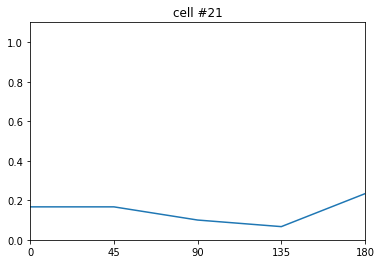

preference is 180 tuning ratio is 1.5701193808961502


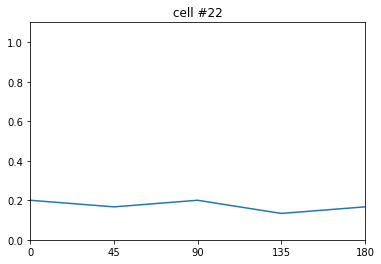

preference is 0 tuning ratio is 1.1552197246213445


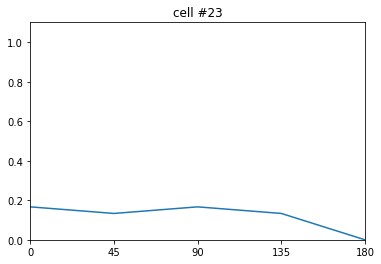

preference is 0 tuning ratio is 1.3802422262934073


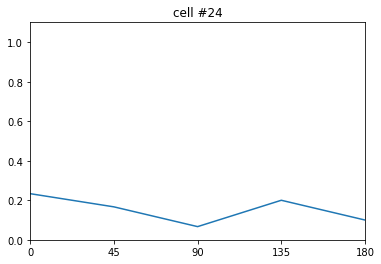

preference is 0 tuning ratio is 1.4778735739888411


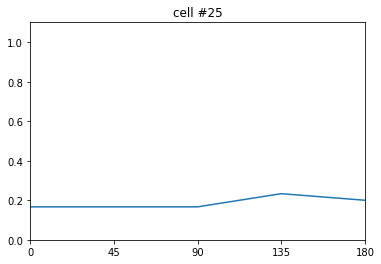

preference is 135 tuning ratio is 1.2473588644356992


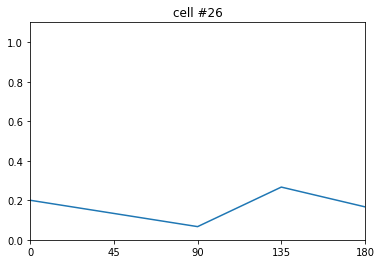

preference is 135 tuning ratio is 1.5714981693761865


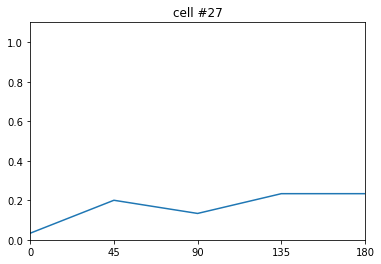

preference is 135 tuning ratio is 1.4129831369358818


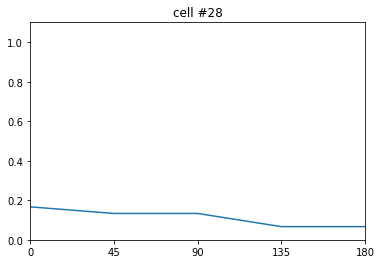

preference is 0 tuning ratio is 1.4273655941453338


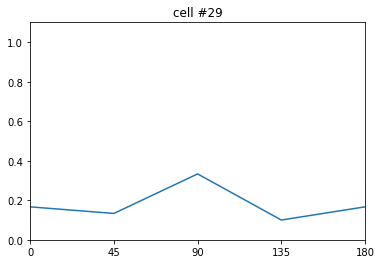

preference is 90 tuning ratio is 1.8265119459997443


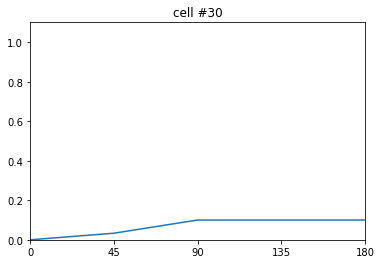

preference is 90 tuning ratio is 1.5156409968851858


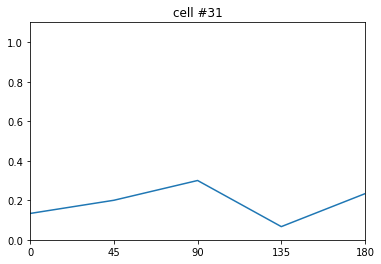

preference is 90 tuning ratio is 1.60236213229447


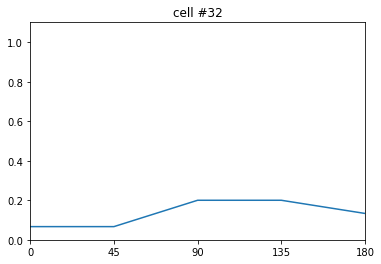

preference is 90 tuning ratio is 1.5094715368350764


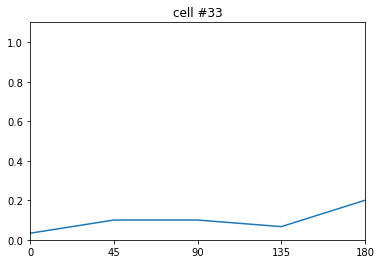

preference is 180 tuning ratio is 1.9826695940076557


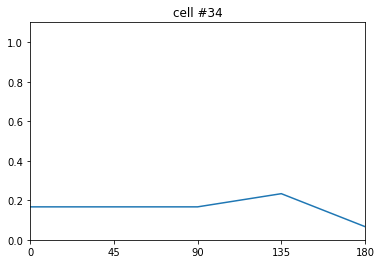

preference is 135 tuning ratio is 1.4489491492958955


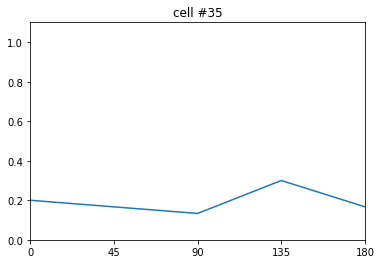

preference is 135 tuning ratio is 1.5325294524192696


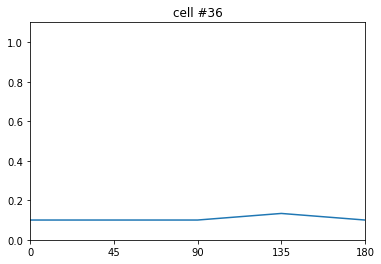

preference is 135 tuning ratio is 1.247736083090959


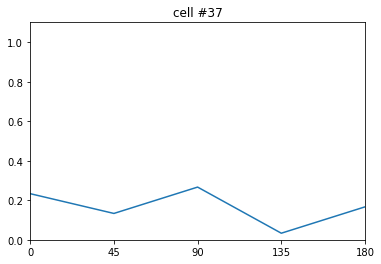

preference is 90 tuning ratio is 1.5846016979409814


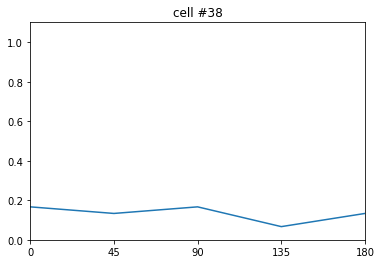

preference is 0 tuning ratio is 1.2503848782282836


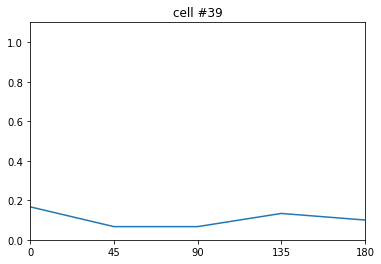

preference is 0 tuning ratio is 1.5203484563583036


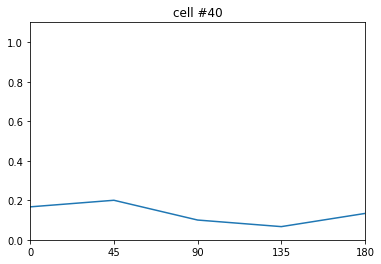

preference is 45 tuning ratio is 1.5004564451588427


In [10]:
SetCoupling(coupling,22)
SetCoupling(couplingA,44)
SetCoupling(coupling3,88)
CrossCoupling(couplingC,66)
CrossCoupling(couplingX,110)
pairedjit = []
pairedspikes = []

RStune = []
RStuneA = []
RStune3 = []
dirpref = []

import matplotlib.pyplot as plt
direction = [0,45,90,135,180]

for l in range(1,21): 
    PLOTRS3 = l+20
    sp0=[]
    sp0A=[]
    sp03=[]

    RSresp = []
    RSrespA = []
    RSresp3 = []

    RSa = 0
    RSaA = 0
    RSa3 = 0
    
    RSavg3 = 0

    time = np.zeros((ASIZE,))

    fsvolt  = np.zeros((numFS,ASIZE))
    fsexc   = np.zeros((numFS,ASIZE))
    fsinh   = np.zeros((numFS,ASIZE))         
    rsvolt  = np.zeros((tRS,ASIZE))
    rsinh   = np.zeros((tRS,ASIZE))
    rsexc   = np.zeros((tRS,ASIZE))
    tcrsexc = np.zeros((tRS,ASIZE))
    rsrsexc = np.zeros((tRS,ASIZE))

    fsvoltA  = np.zeros((numFS,ASIZE))
    fsexcA   = np.zeros((numFS,ASIZE))
    fsinhA   = np.zeros((numFS,ASIZE))         
    rsvoltA  = np.zeros((tRS,ASIZE))
    rsinhA   = np.zeros((tRS,ASIZE))
    rsexcA   = np.zeros((tRS,ASIZE))
    tcrsexcA = np.zeros((tRS,ASIZE))
    rsrsexcA = np.zeros((tRS,ASIZE))

    fsvolt3  = np.zeros((numFS,ASIZE))
    fsexc3   = np.zeros((numFS,ASIZE))
    fsinh3   = np.zeros((numFS,ASIZE))         
    rsvolt3  = np.zeros((tRS,ASIZE))
    rsinh3   = np.zeros((tRS,ASIZE))
    rsexc3   = np.zeros((tRS,ASIZE))
    tcrsexc3 = np.zeros((tRS,ASIZE))
    rsrsexc3 = np.zeros((tRS,ASIZE))

    # temporary storage variables (V, exc, inh) 
    fsv   = np.zeros((numFS,2))
    fse   = np.zeros((numFS,2))
    fsi   = np.zeros((numFS,2))
    rsv   = np.zeros((tRS,2))
    rsi   = np.zeros((tRS,2))
    rse   = np.zeros((tRS,2)) # cross
    tcrse = np.zeros((tRS,2))
    rsrse = np.zeros((tRS,2))

    # temporary storage variables (V, exc, inh) for 2nd barrel
    fsvA   = np.zeros((numFS,2))
    fseA   = np.zeros((numFS,2))
    fsiA   = np.zeros((numFS,2))
    rsvA   = np.zeros((tRS,2))
    rsiA   = np.zeros((tRS,2))
    rseA   = np.zeros((tRS,2)) # cross
    rseX   = np.zeros((tRS,2))
    tcrseA = np.zeros((tRS,2))
    rsrseA = np.zeros((tRS,2))

    fsv3   = np.zeros((numFS,2))
    fse3   = np.zeros((numFS,2))
    fsi3   = np.zeros((numFS,2))
    rsv3   = np.zeros((tRS,2))
    rsi3   = np.zeros((tRS,2))
    rse3   = np.zeros((tRS,2)) # cross
    tcrse3 = np.zeros((tRS,2))
    rsrse3 = np.zeros((tRS,2))

    # track refractory periods for each neuron
    fsref = np.zeros((numFS,))
    rsref = np.zeros((tRS,))
    fsrefA = np.zeros((numFS,))
    rsrefA = np.zeros((tRS,))
    fsref3 = np.zeros((numFS,))
    rsref3 = np.zeros((tRS,))

    # track of spike counts of each neuron (all trials)
    fsspikecount  = np.zeros((trials,numFS),dtype=int)
    rsspikecount  = np.zeros((trials,tRS),dtype=int)
    fsspikecountA  = np.zeros((trials,numFS),dtype=int)
    rsspikecountA  = np.zeros((trials,tRS),dtype=int)  
    fsspikecount3  = np.zeros((trials,numFS),dtype=int)
    rsspikecount3  = np.zeros((trials,tRS),dtype=int)  

    # keep track of how many spikes have been inputed
    fsspiketrack  = np.zeros((numFS,),dtype=int)
    fsspiketrack2 = np.zeros((numFS,),dtype=int) 
    rsspiketrack  = np.zeros((tRS,),dtype=int) 
    fsspiketrackA  = np.zeros((numFS,),dtype=int)
    fsspiketrack2A = np.zeros((numFS,),dtype=int) 
    rsspiketrackA  = np.zeros((tRS,),dtype=int) 
    fsspiketrack3  = np.zeros((numFS,),dtype=int)
    fsspiketrack23 = np.zeros((numFS,),dtype=int) 
    rsspiketrack3  = np.zeros((tRS,),dtype=int) 

    # track spike times of each neuron (all trials)
    fsspiketimes  = np.full((trials,numFS,maxspikes),-1,dtype=float)
    rsspiketimes  = np.full((trials,tRS,maxspikes),-1,dtype=float)  
    fsspiketimesA  = np.full((trials,numFS,maxspikes),-1,dtype=float)
    rsspiketimesA  = np.full((trials,tRS,maxspikes),-1,dtype=float)  
    fsspiketimes3  = np.full((trials,numFS,maxspikes),-1,dtype=float)
    rsspiketimes3  = np.full((trials,tRS,maxspikes),-1,dtype=float)  

    # 
    tempexc = np.zeros((ASIZE,))
    tempinh = np.zeros((ASIZE,))
    tempsyn = np.zeros((ASIZE,))
    tempexcA = np.zeros((ASIZE,))
    tempinhA = np.zeros((ASIZE,))
    tempsynA = np.zeros((ASIZE,))
    tempexc3 = np.zeros((ASIZE,))
    tempinh3 = np.zeros((ASIZE,))
    tempsyn3 = np.zeros((ASIZE,))

    # time,amp of peak tc,rs,exc,inh,syn input to RS cell PLOTRS each trial
    tpeak  = np.zeros((trials,2),dtype=float)
    rpeak  = np.zeros((trials,2),dtype=float)
    epeak  = np.zeros((trials,2),dtype=float)
    ipeak  = np.zeros((trials,2),dtype=float)
    speak  = np.zeros((trials,2),dtype=float)
    fepeak = np.zeros((trials,2),dtype=float)
    fsepeak = np.zeros((trials,2),dtype=float)

    tpeakA  = np.zeros((trials,2),dtype=float)
    rpeakA  = np.zeros((trials,2),dtype=float)
    epeakA  = np.zeros((trials,2),dtype=float)
    ipeakA  = np.zeros((trials,2),dtype=float)
    speakA  = np.zeros((trials,2),dtype=float)
    repeakA = np.zeros((trials,2),dtype=float)
    fepeakA = np.zeros((trials,2),dtype=float)
    fsepeakA = np.zeros((trials,2),dtype=float)

    tpeak3  = np.zeros((trials,2),dtype=float)
    rpeak3  = np.zeros((trials,2),dtype=float)
    epeak3  = np.zeros((trials,2),dtype=float)
    ipeak3  = np.zeros((trials,2),dtype=float)
    speak3  = np.zeros((trials,2),dtype=float)
    repeak3 = np.zeros((trials,2),dtype=float)
    fepeak3 = np.zeros((trials,2),dtype=float)
    fsepeak3 = np.zeros((trials,2),dtype=float)

    for trial in range(1, trials+1):
        
        for z in range(1,6): 

            defdir = z
            tctimes  = np.zeros((tTC))
            tctimesA  = np.zeros((tTC))
            tctimes3  = np.zeros((tTC))
            setTCspike(tctimes,defdir,TCmean)
        #     setTCspike(tctimesA,defdirA,TCmean)
        #     setTCspike(tctimes3,defdirA,TCmean)
            j = 0  
            x = 0
            y = 0
            temp = 0

            for i in range(1,numFS+1):                            # reset current counters
                fsspikecount[trial-1,i-1]=0
                fsspiketrack[i-1]=0
                fsspiketrack2[i-1]=0
                fsv[i-1,1]=0
                fse[i-1,1]=0
                fsi[i-1,1]=0
                fsref[i-1]=0

                fsspikecountA[trial-1,i-1]=0
                fsspiketrackA[i-1]=0
                fsspiketrack2A[i-1]=0
                fsvA[i-1,1]=0
                fseA[i-1,1]=0
                fsiA[i-1,1]=0
                fsrefA[i-1]=0

                fsspikecount3[trial-1,i-1]=0
                fsspiketrack3[i-1]=0
                fsspiketrack23[i-1]=0
                fsv3[i-1,1]=0
                fse3[i-1,1]=0
                fsi3[i-1,1]=0
                fsref3[i-1]=0

            for i in range(1,tRS+1):
                rsspikecount[trial-1,i-1]=0
                rsspiketrack[i-1]=0
                rsv[i-1,1]=0
                rsi[i-1,1]=0
                rsref[i-1]=0
                tcrse[i-1,1]=0
                rsrse[i-1,1]=0
                rse[i-1,1]=0

                rsspikecountA[trial-1,i-1]=0
                rsspiketrackA[i-1]=0
                rsvA[i-1,1]=0
                rsiA[i-1,1]=0
                rsrefA[i-1]=0
                rsrseA[i-1,1]=0
                tcrseA[i-1,1]=0
                rseA[i-1,1]=0

                rsspikecount3[trial-1,i-1]=0
                rsspiketrack3[i-1]=0
                rsv3[i-1,1]=0
                rsi3[i-1,1]=0
                rsref3[i-1]=0
                rsrse3[i-1,1]=0
                tcrse3[i-1,1]=0
                rse3[i-1,1]=0

            tpeak[trial-1,1] = 0.0
            rpeak[trial-1,1] = 0.0
            epeak[trial-1,1] = 0.0
            ipeak[trial-1,1] = 0.0
            speak[trial-1,1] = 0.0
            fepeak[trial-1,1] = 0.0
            fsepeak[trial-1,1] = 0.0

            tpeakA[trial-1,1] = 0.0
            rpeakA[trial-1,1] = 0.0
            repeakA[trial-1,1] = 0.0
            epeakA[trial-1,1] = 0.0
            ipeakA[trial-1,1] = 0.0
            speakA[trial-1,1] = 0.0
            fepeakA[trial-1,1] = 0.0
            fsepeakA[trial-1,1] = 0.0

            tpeak3[trial-1,1] = 0.0
            rpeak3[trial-1,1] = 0.0
            repeak3[trial-1,1] = 0.0
            epeak3[trial-1,1] = 0.0
            ipeak3[trial-1,1] = 0.0
            speak3[trial-1,1] = 0.0
            fepeak3[trial-1,1] = 0.0
            fsepeak3[trial-1,1] = 0.0

            for i in range(1,NSTEPS+1): 

                for k in range(1, numFS+1):                 # move current time slots into previous time slots
                    fsv[k-1,0] = fsv[k-1,1]                 # later use time slots to check if a cell spiked
                    fse[k-1,0] = fse[k-1,1]
                    fsi[k-1,0] = fsi[k-1,1]
                for k in range(1, tRS+1):
                    rsv[k-1,0] = rsv[k-1,1]
                    rsi[k-1,0] = rsi[k-1,1]
                    rse[k-1,0] = rse[k-1,1]
                    tcrse[k-1,0] = tcrse[k-1,1]
                    rsrse[k-1,0] = rsrse[k-1,1]

                for k in range(1, numFS+1):                 
                    fsvA[k-1,0] = fsvA[k-1,1]
                    fseA[k-1,0] = fseA[k-1,1]
                    fsiA[k-1,0] = fsiA[k-1,1]
                for k in range(1, tRS+1):
                    rsvA[k-1,0] = rsvA[k-1,1]
                    rsiA[k-1,0] = rsiA[k-1,1]
                    rseA[k-1,0] = rseA[k-1,1]
                    tcrseA[k-1,0] = tcrseA[k-1,1]
                    rsrseA[k-1,0] = rsrseA[k-1,1]

                for k in range(1, numFS+1):                 
                    fsv3[k-1,0] = fsv3[k-1,1]
                    fse3[k-1,0] = fse3[k-1,1]
                    fsi3[k-1,0] = fsi3[k-1,1]
                for k in range(1, tRS+1):
                    rsv3[k-1,0] = rsv3[k-1,1]
                    rsi3[k-1,0] = rsi3[k-1,1]
                    rse3[k-1,0] = rse3[k-1,1]
                    tcrse3[k-1,0] = tcrse3[k-1,1]
                    rsrse3[k-1,0] = rsrse3[k-1,1]

                # refractory period
                for k in range(1,numFS+1):                  # track FS refractory period
                    if fsref[k-1] >= refsteps: 
                        fsref[k-1] = 0
                    if fsref[k-1] != 0: 
                        fsref[k-1] += 1
                for k in range(1, tRS+1):                   # track RS refractory period
                    if rsref[k-1] >= refsteps: 
                        rsref[k-1] = 0
                    if rsref[k-1] != 0: 
                        rsref[k-1] += 1

                for k in range(1,numFS+1):                  # track FS refractory period
                    if fsrefA[k-1] >= refsteps: 
                        fsrefA[k-1] = 0
                    if fsrefA[k-1] != 0: 
                        fsrefA[k-1] += 1
                for k in range(1, tRS+1):                   # track RS refractory period
                    if rsrefA[k-1] >= refsteps: 
                        rsrefA[k-1] = 0
                    if rsrefA[k-1] != 0: 
                        rsrefA[k-1] += 1

                for k in range(1,numFS+1):                  # track FS refractory period
                    if fsref3[k-1] >= refsteps: 
                        fsref3[k-1] = 0
                    if fsref3[k-1] != 0: 
                        fsref3[k-1] += 1
                for k in range(1, tRS+1):                   # track RS refractory period
                    if rsref3[k-1] >= refsteps: 
                        rsref3[k-1] = 0
                    if rsref3[k-1] != 0: 
                        rsref3[k-1] += 1

                # barrel 1 V_m
                for k in range(1,numFS+1): 
                    if fsref[k-1] != 0:
                        fsv[k-1,1] = V_rest
                    else: 
                        dvdt = -g_L*(fsv[k-1,0]-V_rest) + fse[k-1,0] - fsi[k-1,0]
                        fsv[k-1,1] = fsv[k-1,0] + TSTEP*dvdt
                    fsi[k-1,1] = fsi[k-1,0]*(math.exp(-fsfsD*TSTEP))
                    fse[k-1,1] = fse[k-1,0]*(math.exp(-tcfsD*TSTEP))
                for k in range(1,tRS+1): 
                    if rsref[k-1] != 0: 
                        rsv[k-1,1] = V_rest
                    else: 
                        dvdt = -g_L*(rsv[k-1,0]-V_rest) - rsi[k-1,0] + tcrse[k-1,0] + rsrse[k-1,0] + rse[k-1,0]
                        rsv[k-1,1] = rsv[k-1,0] + TSTEP*dvdt
                    rsi[k-1,1] = rsi[k-1,0]*(math.exp(-fsrsD*TSTEP))
                    rse[k-1,1] = rse[k-1,0]*(math.exp(-rsrsD*TSTEP))
                    tcrse[k-1,1] = tcrse[k-1,0]*(math.exp(-tcrsD*TSTEP))
                    rsrse[k-1,1] = rsrse[k-1,0]*(math.exp(-rsrsD*TSTEP))

                # barrel 2 V_m
                for k in range(1,numFS+1): 
                    if fsrefA[k-1] != 0:
                        fsvA[k-1,1] = V_rest
                    else: 
                        dvdt = -g_L*(fsvA[k-1,0]-V_rest) + fseA[k-1,0] - fsiA[k-1,0]
                        fsvA[k-1,1] = fsvA[k-1,0] + TSTEP*dvdt
                    fsiA[k-1,1] = fsiA[k-1,0]*(math.exp(-fsfsD*TSTEP))
                    fseA[k-1,1] = fseA[k-1,0]*(math.exp(-tcfsD*TSTEP))
                for k in range(1,tRS+1): 
                    if rsrefA[k-1] != 0: 
                        rsvA[k-1,1] = V_rest
                    else: 
                        dvdt = -g_L*(rsvA[k-1,0]-V_rest) - rsiA[k-1,0] + rseA[k-1,0] + tcrseA[k-1,0] + rsrseA[k-1,0]
                        rsvA[k-1,1] = rsvA[k-1,0] + TSTEP*dvdt
                    rsiA[k-1,1] = rsiA[k-1,0]*(math.exp(-fsrsD*TSTEP))
                    rseA[k-1,1] = rseA[k-1,0]*(math.exp(-rsrsD*TSTEP))
                    tcrseA[k-1,1] = tcrseA[k-1,0]*(math.exp(-tcrsD*TSTEP))
                    rsrseA[k-1,1] = rsrseA[k-1,0]*(math.exp(-rsrsD*TSTEP))

                # barrel 3 V_m
                for k in range(1,numFS+1): 
                    if fsref3[k-1] != 0:
                        fsv3[k-1,1] = V_rest
                    else: 
                        dvdt = -g_L*(fsv3[k-1,0]-V_rest) + fse3[k-1,0] - fsi3[k-1,0]
                        fsv3[k-1,1] = fsv3[k-1,0] + TSTEP*dvdt
                    fsi3[k-1,1] = fsi3[k-1,0]*(math.exp(-fsfsD*TSTEP))
                    fse3[k-1,1] = fse3[k-1,0]*(math.exp(-tcfsD*TSTEP))
                for k in range(1,tRS+1): 
                    if rsref3[k-1] != 0: 
                        rsv3[k-1,1] = V_rest
                    else: 
                        dvdt = -g_L*(rsv3[k-1,0]-V_rest) - rsi3[k-1,0] + rse3[k-1,0] + tcrse3[k-1,0] + rsrse3[k-1,0]
                        rsv3[k-1,1] = rsv3[k-1,0] + TSTEP*dvdt
                    rsi3[k-1,1] = rsi3[k-1,0]*(math.exp(-fsrsD*TSTEP))
                    rse3[k-1,1] = rse3[k-1,0]*(math.exp(-rsrsD*TSTEP))
                    tcrse3[k-1,1] = tcrse3[k-1,0]*(math.exp(-tcrsD*TSTEP))
                    rsrse3[k-1,1] = rsrse3[k-1,0]*(math.exp(-rsrsD*TSTEP))

        # ===============================================================================================

            # 1st barrel

                for k in range(1,numFS+1):                  # check and track FS spikes
                    if (fsv[k-1,1] >= threshold and fsv[k-1,0] < threshold): 
                        fsv[k-1,1] = V_rest
                        fsspikecount[trial-1,k-1] += 1
                        fsspiketimes[trial-1,k-1,fsspikecount[trial-1,k-1]-1] = i*TSTEP
                        fsref[k-1] = 1
                for k in range(1,tRS+1):                    # check and track RS spikes
                    if (rsv[k-1,1] >= threshold and rsv[k-1,0] < threshold):
                        rsv[k-1,1] = V_rest
                        rsspikecount[trial-1,k-1] += 1
                        rsspiketimes[trial-1,k-1,rsspikecount[trial-1,k-1]-1] = i*TSTEP
                        rsref[k-1] = 1

                for k in range(1,tTC+1):                    # calculate synaptic inputs from TC spikes
                    if ((tctimes[k-1] < i*TSTEP) and (tctimes[k-1] > ((i-1) * TSTEP))): 
                        for m in range(tTC+1,(tTC+numFS)+1): 
                            fse[m-tTC-1,1] += tcfsA*(coupling[k-1,m-1])
                        for m in range(tTC+numFS+1,tcells+1): 
                            tcrse[m-(tTC+numFS)-1,1] += tcrsA*coupling[k-1,m-1]

                for k in range(1,numFS+1):                  # calculate FSFS and FSRS synaptic inputs
                    temp=fsspiketrack2[k-1]+1               # track FS active in current trial
                    for m in range(temp,fsspikecount[trial-1,k-1]+1):
                        if (fsspiketimes[trial-1,k-1,m-1] + fsfsSD <= i*TSTEP and 
                            fsspiketimes[trial-1,k-1,m-1] + fsfsSD > (i-1)*TSTEP): 
                            fsspiketrack2[k-1] += 1
                            for n in range(1,numFS+1): 
                                fsi[n-1,1] += fsfsA * coupling[tTC+k-1,tTC+n-1]
                    temp=fsspiketrack[k-1]+1                # same as above but for FSRS
                    for m in range(temp,fsspikecount[trial-1,k-1]+1):
                        if (fsspiketimes[trial-1,k-1,m-1] + fsrsSD <= i*TSTEP and 
                            fsspiketimes[trial-1,k-1,m-1] + fsrsSD > (i-1)*TSTEP):
                            fsspiketrack[k-1] += 1
                            for n in range(1,tRS+1):
                                rsi[n-1,1] += fsrsA * coupling[tTC+k-1,tTC+numFS+n-1]

                for k in range(1,tRS+1):                    # calculate RSRS synaptic inputs
                    temp=rsspiketrack[k-1]+1
                    for m in range(temp,rsspikecount[trial-1,k-1]+1):
                        if (((rsspiketimes[trial-1,k-1,m-1] + rsrsSD) <= i*TSTEP) and
                           ((rsspiketimes[trial-1,k-1,m-1] + rsrsSD) > (i-1)*TSTEP)): 
                            rsspiketrack[k-1] += 1
                            for n in range(1,tRS+1): 
                                rsrse[n-1,1] += rsrsA * coupling[tTC+numFS+k-1,tTC+numFS+n-1]

                        if (((rsspiketimes[trial-1,k-1,m-1] + rsrsSDA) <= i*TSTEP) and
                           ((rsspiketimes[trial-1,k-1,m-1] + rsrsSDA) > (i-1)*TSTEP)): 
                            for n in range(1,tRS+1): 
                                rseA[n-1,1] += rsrsAA * couplingC[tTC+numFS+k-1,tTC+numFS+n-1]
                            for n in range(1,numFS+1):
                                fseA[n-1,1] += rsfsAA * couplingC[tTC+k-1,tTC+numFS+n-1] 

                # track of peak time,amp in tc,rs,net exc,inh,syn input to RS cell PLOTRS
                if tcrse[PLOTRS-1,1] > tpeak[trial-1,1]:                              
                    tpeak[trial-1,0] = i*TSTEP
                    tpeak[trial-1,1] = tcrse[PLOTRS-1,1]
                if rsrse[PLOTRS-1,1] > rpeak[trial-1,1]: 
                    rpeak[trial-1,0] = i*TSTEP
                    rpeak[trial-1,1] = rsrse[PLOTRS-1,1]
                if tcrse[PLOTRS-1,1] + rsrse[PLOTRS-1,1] > epeak[trial-1,1]: 
                    epeak[trial-1,0] = i*TSTEP
                    epeak[trial-1,1] = tcrse[PLOTRS-1,1] + rsrse[PLOTRS-1,1]
                if rsi[PLOTRS-1,1]   > ipeak[trial-1,1]: 
                    ipeak[trial-1,0] = i*TSTEP
                    ipeak[trial-1,1] = rsi[PLOTRS-1,1]
                if tcrse[PLOTRS-1,1] + rsrse[PLOTRS-1,1] - rsi[PLOTRS-1,1] > speak[trial-1,1]: 
                    speak[trial-1,0] = i*TSTEP
                    speak[trial-1,1] = tcrse[PLOTRS-1,1] + rsrse[PLOTRS-1,1] - rsi[PLOTRS-1,1]
                if (tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1]+rsi[PLOTRS-1,1]) != 0:
                    if (((tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1])
                         /(tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1]+rsi[PLOTRS-1,1]))>fepeak[trial-1,1]):
                        fepeak[trial-1,0]= i*TSTEP
                        fepeak[trial-1,1]= ((tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1])/
                                           (tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1]+rsi[PLOTRS-1,1]))

                if fse[PLOTRS-1,1] > fsepeak[trial-1,1]: 
                    fsepeak[trial-1,0] = i*TSTEP
                    fsepeak[trial-1,1] = fseA[PLOTRS-1,1]

                # record everything
                j += 1
                time[j-1] = i*TSTEP
                for k in range(1,numFS+1): 
                    fsvolt[k-1,j-1]  = fsv[k-1,1]
                    fsinh[k-1,j-1]   = fsi[k-1,1]
                    fsexc[k-1,j-1]   = fse[k-1,1]
                for k in range(1,tRS+1): 
                    rsvolt[k-1,j-1]  = rsv[k-1,1]
                    rsinh[k-1,j-1]   = rsi[k-1,1]
                    tcrsexc[k-1,j-1] = tcrse[k-1,1]
                    rsrsexc[k-1,j-1] = rsrse[k-1,1]

        # ===============================================================================================   

                # 2nd barrel
                temp = 0

                # check and track spikes
                for k in range(1,numFS+1):
                    if (fsvA[k-1,1] >= threshold and fsvA[k-1,0] < threshold): 
                        fsvA[k-1,1] = V_rest
                        fsspikecountA[trial-1,k-1] += 1
                        fsspiketimesA[trial-1,k-1,fsspikecountA[trial-1,k-1]-1] = i*TSTEP
                        fsrefA[k-1] = 1

                for k in range(1,tRS+1):
                    if (rsvA[k-1,1] >= threshold and rsvA[k-1,0] < threshold):
                        rsvA[k-1,1] = V_rest
                        rsspikecountA[trial-1,k-1] += 1
                        rsspiketimesA[trial-1,k-1,rsspikecountA[trial-1,k-1]-1] = i*TSTEP
                        rsrefA[k-1] = 1

                for k in range(1,tTC+1):                    # calculate synaptic inputs from TC spikes
                    if ((tctimesA[k-1] < i*TSTEP) and (tctimesA[k-1] > ((i-1) * TSTEP))): 
                        for m in range(tTC+1,(tTC+numFS)+1): 
                            fseA[m-tTC-1,1] += tcfsA*(couplingA[k-1,m-1])
                        for m in range(tTC+numFS+1,tcells+1): 
                            tcrseA[m-(tTC+numFS)-1,1] += tcrsA*couplingA[k-1,m-1]

                # calculate synaptic inputs (intra barrel synapses)

                # FSFS and FSRS
                for k in range(1,numFS+1):                  
                    temp=fsspiketrack2A[k-1]+1
                    for m in range(temp,fsspikecountA[trial-1,k-1]+1):
                        if (fsspiketimesA[trial-1,k-1,m-1] + fsfsSD <= i*TSTEP and 
                            fsspiketimesA[trial-1,k-1,m-1] + fsfsSD > (i-1)*TSTEP): 
                            fsspiketrack2A[k-1] += 1
                            for n in range(1,numFS+1): 
                                fsiA[n-1,1] += fsfsA * couplingA[tTC+k-1,tTC+n-1]
                    temp=fsspiketrackA[k-1]+1
                    for m in range(temp,fsspikecountA[trial-1,k-1]+1):
                        if (fsspiketimesA[trial-1,k-1,m-1] + fsrsSD <= i*TSTEP and 
                            fsspiketimesA[trial-1,k-1,m-1] + fsrsSD > (i-1)*TSTEP):
                            fsspiketrackA[k-1] += 1
                            for n in range(1,tRS+1):
                                rsiA[n-1,1] += fsrsA * couplingA[tTC+k-1,tTC+numFS+n-1]

                # RSRS                        
                for k in range(1,tRS+1):
                    temp=rsspiketrackA[k-1]+1
                    for m in range(temp,rsspikecountA[trial-1,k-1]+1):
                        if (((rsspiketimesA[trial-1,k-1,m-1] + rsrsSD) <= i*TSTEP) and
                           ((rsspiketimesA[trial-1,k-1,m-1] + rsrsSD) > (i-1)*TSTEP)): 
                            rsspiketrackA[k-1] += 1
                            for n in range(1,tRS+1): 
                                rsrseA[n-1,1] += rsrsA * couplingA[tTC+numFS+k-1,tTC+numFS+n-1]

                        if (((rsspiketimesA[trial-1,k-1,m-1] + rsrsSDA) <= i*TSTEP) and
                           ((rsspiketimesA[trial-1,k-1,m-1] + rsrsSDA) > (i-1)*TSTEP)): 
                            for n in range(1,tRS+1): 
                                rse[n-1,1] += rsrsAA * couplingC[tTC+numFS+k-1,tTC+numFS+n-1]
                                rse3[n-1,1] += rsrsAA * couplingX[tTC+numFS+k-1,tTC+numFS+n-1]
                            for n in range(1,numFS+1):
                                fse[n-1,1] += rsfsAA * couplingC[tTC+k-1,tTC+numFS+n-1]
                                fse3[n-1,1] += rsfsAA * couplingX[tTC+k-1,tTC+numFS+n-1]

                # track peaks

                if tcrseA[PLOTRSA-1,1] > tpeakA[trial-1,1]:                              
                    tpeakA[trial-1,0] = i*TSTEP
                    tpeakA[trial-1,1] = tcrseA[PLOTRSA-1,1]
                if rseA[PLOTRSA-1,1] > repeakA[trial-1,1]:                              
                    repeakA[trial-1,0] = i*TSTEP
                    repeakA[trial-1,1] = rseA[PLOTRSA-1,1]
                if rsrseA[PLOTRSA-1,1] > rpeakA[trial-1,1]: 
                    rpeakA[trial-1,0] = i*TSTEP
                    rpeakA[trial-1,1] = rsrseA[PLOTRSA-1,1]
                if rseA[PLOTRSA-1,1] + rsrseA[PLOTRSA-1,1] > epeakA[trial-1,1]: 
                    epeakA[trial-1,0] = i*TSTEP
                    epeakA[trial-1,1] = rseA[PLOTRSA-1,1] + rsrseA[PLOTRSA-1,1]
                if rsiA[PLOTRSA-1,1]   > ipeakA[trial-1,1]: 
                    ipeakA[trial-1,0] = i*TSTEP
                    ipeakA[trial-1,1] = rsiA[PLOTRSA-1,1]
                if rseA[PLOTRSA-1,1] + rsrseA[PLOTRSA-1,1] - rsiA[PLOTRSA-1,1] > speakA[trial-1,1]: 
                    speakA[trial-1,0] = i*TSTEP
                    speakA[trial-1,1] = rseA[PLOTRSA-1,1] + rsrseA[PLOTRSA-1,1] - rsiA[PLOTRSA-1,1]
                if (rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1]+rsiA[PLOTRSA-1,1]) != 0:
                    if (((rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1])
                         /(rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1]+rsiA[PLOTRSA-1,1]))>fepeakA[trial-1,1]):
                        fepeakA[trial-1,0]= i*TSTEP
                        fepeakA[trial-1,1]= ((rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1])/
                                           (rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1]+rsiA[PLOTRSA-1,1]))

                if fseA[PLOTRSA-1,1] > fsepeakA[trial-1,1]: 
                    fsepeakA[trial-1,0] = i*TSTEP
                    fsepeakA[trial-1,1] = fseA[PLOTRSA-1,1]

                # record everything
                x += 1
                time[x-1] = i*TSTEP
                for k in range(1,numFS+1): 
                    fsvoltA[k-1,x-1]  = fsvA[k-1,1]
                    fsinhA[k-1,x-1]   = fsiA[k-1,1]
                    fsexcA[k-1,x-1]   = fseA[k-1,1]
                for k in range(1,tRS+1): 
                    rsvoltA[k-1,x-1]  = rsvA[k-1,1]
                    rsinhA[k-1,x-1]   = rsiA[k-1,1]
                    rsexcA[k-1,x-1]   = rseA[k-1,1]
                    rsrsexcA[k-1,x-1] = rsrseA[k-1,1]
                    tcrsexcA[k-1,x-1] = tcrseA[k-1,1]

        # # ===============================================================================================   

                # 3rd barrel
                temp = 0

                # check and track spikes
                for k in range(1,numFS+1):
                    if (fsv3[k-1,1] >= threshold and fsv3[k-1,0] < threshold): 
                        fsv3[k-1,1] = V_rest
                        fsspikecount3[trial-1,k-1] += 1
                        fsspiketimes3[trial-1,k-1,fsspikecount3[trial-1,k-1]-1] = i*TSTEP
                        fsref3[k-1] = 1

                for k in range(1,tRS+1):
                    if (rsv3[k-1,1] >= threshold and rsv3[k-1,0] < threshold):
                        rsv3[k-1,1] = V_rest
                        rsspikecount3[trial-1,k-1] += 1
                        rsspiketimes3[trial-1,k-1,rsspikecount3[trial-1,k-1]-1] = i*TSTEP
                        rsref3[k-1] = 1

                for k in range(1,tTC+1):                    # calculate synaptic inputs from TC spikes
                    if ((tctimes3[k-1] < i*TSTEP) and (tctimes3[k-1] > ((i-1) * TSTEP))): 
                        for m in range(tTC+1,(tTC+numFS)+1): 
                            fse3[m-tTC-1,1] += tcfsA*(coupling3[k-1,m-1])
                        for m in range(tTC+numFS+1,tcells+1): 
                            tcrse3[m-(tTC+numFS)-1,1] += tcrsA*coupling3[k-1,m-1]

                # calculate synaptic inputs (intra barrel synapses)

                # FSFS and FSRS
                for k in range(1,numFS+1):                  
                    temp=fsspiketrack23[k-1]+1
                    for m in range(temp,fsspikecount3[trial-1,k-1]+1):
                        if (fsspiketimes3[trial-1,k-1,m-1] + fsfsSD <= i*TSTEP and 
                            fsspiketimes3[trial-1,k-1,m-1] + fsfsSD > (i-1)*TSTEP): 
                            fsspiketrack23[k-1] += 1
                            for n in range(1,numFS+1): 
                                fsi3[n-1,1] += fsfsA * coupling3[tTC+k-1,tTC+n-1]
                    temp=fsspiketrack3[k-1]+1
                    for m in range(temp,fsspikecount3[trial-1,k-1]+1):
                        if (fsspiketimes3[trial-1,k-1,m-1] + fsrsSD <= i*TSTEP and 
                            fsspiketimes3[trial-1,k-1,m-1] + fsrsSD > (i-1)*TSTEP):
                            fsspiketrack3[k-1] += 1
                            for n in range(1,tRS+1):
                                rsi3[n-1,1] += fsrsA * coupling3[tTC+k-1,tTC+numFS+n-1]

                # RSRS                        
                for k in range(1,tRS+1):
                    temp=rsspiketrack3[k-1]+1
                    for m in range(temp,rsspikecount3[trial-1,k-1]+1):
                        if (((rsspiketimes3[trial-1,k-1,m-1] + rsrsSD) <= i*TSTEP) and
                           ((rsspiketimes3[trial-1,k-1,m-1] + rsrsSD) > (i-1)*TSTEP)): 
                            rsspiketrack3[k-1] += 1
                            for n in range(1,tRS+1): 
                                rsrse3[n-1,1] += rsrsA * coupling3[tTC+numFS+k-1,tTC+numFS+n-1]

                        if (((rsspiketimes3[trial-1,k-1,m-1] + rsrsSDA) <= i*TSTEP) and
                           ((rsspiketimes3[trial-1,k-1,m-1] + rsrsSDA) > (i-1)*TSTEP)): 
                            for n in range(1,tRS+1): 
                                rseA[n-1,1] += rsrsAA * couplingX[tTC+numFS+k-1,tTC+numFS+n-1]
                            for n in range(1,numFS+1):
                                fseA[n-1,1] += rsfsAA * couplingX[tTC+k-1,tTC+numFS+n-1] 

                # track peaks

                if tcrse3[PLOTRSA-1,1] > tpeak3[trial-1,1]:                              
                    tpeak3[trial-1,0] = i*TSTEP
                    tpeak3[trial-1,1] = tcrse3[PLOTRSA-1,1]
                if rse3[PLOTRSA-1,1] > repeak3[trial-1,1]:                              
                    repeak3[trial-1,0] = i*TSTEP
                    repeak3[trial-1,1] = rse3[PLOTRSA-1,1]
                if rsrse3[PLOTRSA-1,1] > rpeak3[trial-1,1]: 
                    rpeak3[trial-1,0] = i*TSTEP
                    rpeak3[trial-1,1] = rsrse3[PLOTRSA-1,1]
                if rse3[PLOTRSA-1,1] + rsrse3[PLOTRSA-1,1] > epeak3[trial-1,1]: 
                    epeak3[trial-1,0] = i*TSTEP
                    epeak3[trial-1,1] = rse3[PLOTRSA-1,1] + rsrse3[PLOTRSA-1,1]
                if rsi3[PLOTRSA-1,1]   > ipeak3[trial-1,1]: 
                    ipeak3[trial-1,0] = i*TSTEP
                    ipeak3[trial-1,1] = rsi3[PLOTRSA-1,1]
                if rse3[PLOTRSA-1,1] + rsrse3[PLOTRSA-1,1] - rsi3[PLOTRSA-1,1] > speak3[trial-1,1]: 
                    speak3[trial-1,0] = i*TSTEP
                    speak3[trial-1,1] = rse3[PLOTRSA-1,1] + rsrse3[PLOTRSA-1,1] - rsi3[PLOTRSA-1,1]
                if (rse3[PLOTRSA-1,1]+rsrse3[PLOTRSA-1,1]+rsi3[PLOTRSA-1,1]) != 0:
                    if (((rse3[PLOTRSA-1,1]+rsrse3[PLOTRSA-1,1])
                         /(rse3[PLOTRSA-1,1]+rsrse3[PLOTRSA-1,1]+rsi3[PLOTRSA-1,1]))>fepeak3[trial-1,1]):
                        fepeak3[trial-1,0]= i*TSTEP
                        fepeak3[trial-1,1]= ((rse3[PLOTRSA-1,1]+rsrse3[PLOTRSA-1,1])/
                                           (rse3[PLOTRSA-1,1]+rsrse3[PLOTRSA-1,1]+rsi3[PLOTRSA-1,1]))

                if fse3[PLOTRSA-1,1] > fsepeak3[trial-1,1]: 
                    fsepeak3[trial-1,0] = i*TSTEP
                    fsepeak3[trial-1,1] = fse3[PLOTRSA-1,1]

                # record everything
                y += 1
                time[k-1] = i*TSTEP
                for k in range(1,numFS+1): 
                    fsvolt3[k-1,y-1]  = fsv3[k-1,1]
                    fsinh3[k-1,y-1]   = fsi3[k-1,1]
                    fsexc3[k-1,y-1]   = fse3[k-1,1]
                for k in range(1,tRS+1): 
                    rsvolt3[k-1,y-1]  = rsv3[k-1,1]
                    rsinh3[k-1,y-1]   = rsi3[k-1,1]
                    rsexc3[k-1,y-1]   = rse3[k-1,1]
                    rsrsexc3[k-1,y-1] = rsrse3[k-1,1]
                    tcrsexc3[k-1,y-1] = tcrse3[k-1,1]
                    
    # ===============================================================================================

        rsspmean3  = np.zeros((tRS,),dtype=float)

        
#         # avg spikes
#         for i in range(1,tRS+1): 
#             rsspmeanA[i-1] = 0
#             for k in range(1,trials+1): 
#                 rsspmeanA[i-1] += rsspikecountA[k-1,i-1]
#             rsspmeanA[i-1] /= trials
            
        # avg spikes
        for i in range(1,tRS+1): 
            rsspmean3[i-1] = 0
            for k in range(1,trials+1): 
                rsspmean3[i-1] += rsspikecount3[k-1,i-1]
            rsspmean3[i-1] /= trials
        
#         sp0A.append(rsspmeanA[PLOTRSA-1])
        sp03.append(rsspmean3[PLOTRS3-1])
        
        # RS tuning
#         for i in range(1,trials+1): 
#             RSavg += rsspikecount[i-1,PLOTRS-1]
#         RSavg /= trials
        
#         for i in range(1,trials+1): 
#             RSavgA += rsspikecountA[i-1,PLOTRSA-1]
#         RSavgA /= trials

        for i in range(1,trials+1): 
            RSavg3 += rsspikecount3[i-1,PLOTRS3-1]
        RSavg3 /= trials

#         RSresp.append(RSavg)
#         RSrespA.append(RSavgA)
        RSresp3.append(RSavg3)

#     RSa = sum(RSresp)/len(RSresp)
#     RSaA = sum(RSrespA)/len(RSrespA)
    RSa3 = sum(RSresp3)/len(RSresp3)

#     RStune.append(max(RSresp)/RSa)
#     RStuneA.append(max(RSrespA)/RSaA)
    RStune3.append(max(RSresp3)/RSa3)
    
    plt.figure()
    plt.title('cell #' + str(l+20))
    plt.plot(direction, sp03)
    plt.axis([0,180,0,1.1])
    plt.xticks([0,45,90,135,180])
    plt.show()
    print('preference is',np.argmax(sp03)*45,'tuning ratio is',RStune3[l-1])
    dirpref.append(np.argmax(sp03)*45)
    
#     dirpref1.append(np.argmax(sp0)*45)
#     dirpref2.append(np.argmax(sp0A)*45)

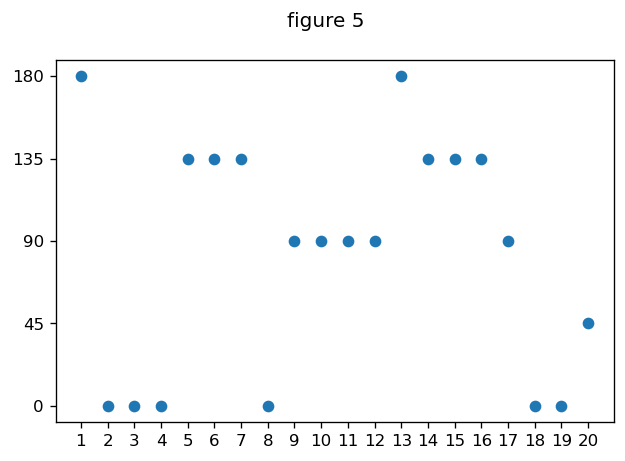

In [11]:
import matplotlib.pyplot as plt
x = list(range(1,21))
y = dirpref

plt.figure(dpi=120)
plt.suptitle('figure 5')
plt.scatter(x,y)
plt.yticks([0,45,90,135,180])
plt.xticks(range(1,21))
plt.show()

In [8]:
SetCoupling(coupling,22)
SetCoupling(couplingA,44)
SetCoupling(coupling3,88)
CrossCoupling(couplingC,66)
CrossCoupling(couplingX,110)
pairedjit = []
pairedspikes = []

trials = 100

RStune = []
RStuneA = []
RStune3 = []
dirpref = []

PLOTRS3 = 28
PLOTRSA = 85
PLOTRS = 64

import matplotlib.pyplot as plt
direction = [0,45,90,135,180]

sp0=[]
sp0A=[]
sp03=[]

RSresp = []
RSrespA = []
RSresp3 = []

RSa = 0
RSaA = 0
RSa3 = 0

RSavg = 0
RSavgA = 0
RSavg3 = 0

for z in range(1,6): 

    defdir = z+2

    time = np.zeros((ASIZE,))

    fsvolt  = np.zeros((numFS,ASIZE))
    fsexc   = np.zeros((numFS,ASIZE))
    fsinh   = np.zeros((numFS,ASIZE))         
    rsvolt  = np.zeros((tRS,ASIZE))
    rsinh   = np.zeros((tRS,ASIZE))
    rsexc   = np.zeros((tRS,ASIZE))
    tcrsexc = np.zeros((tRS,ASIZE))
    rsrsexc = np.zeros((tRS,ASIZE))

    fsvoltA  = np.zeros((numFS,ASIZE))
    fsexcA   = np.zeros((numFS,ASIZE))
    fsinhA   = np.zeros((numFS,ASIZE))         
    rsvoltA  = np.zeros((tRS,ASIZE))
    rsinhA   = np.zeros((tRS,ASIZE))
    rsexcA   = np.zeros((tRS,ASIZE))
    tcrsexcA = np.zeros((tRS,ASIZE))
    rsrsexcA = np.zeros((tRS,ASIZE))

    fsvolt3  = np.zeros((numFS,ASIZE))
    fsexc3   = np.zeros((numFS,ASIZE))
    fsinh3   = np.zeros((numFS,ASIZE))         
    rsvolt3  = np.zeros((tRS,ASIZE))
    rsinh3   = np.zeros((tRS,ASIZE))
    rsexc3   = np.zeros((tRS,ASIZE))
    tcrsexc3 = np.zeros((tRS,ASIZE))
    rsrsexc3 = np.zeros((tRS,ASIZE))

    # temporary storage variables (V, exc, inh) 
    fsv   = np.zeros((numFS,2))
    fse   = np.zeros((numFS,2))
    fsi   = np.zeros((numFS,2))
    rsv   = np.zeros((tRS,2))
    rsi   = np.zeros((tRS,2))
    rse   = np.zeros((tRS,2)) # cross
    tcrse = np.zeros((tRS,2))
    rsrse = np.zeros((tRS,2))

    # temporary storage variables (V, exc, inh) for 2nd barrel
    fsvA   = np.zeros((numFS,2))
    fseA   = np.zeros((numFS,2))
    fsiA   = np.zeros((numFS,2))
    rsvA   = np.zeros((tRS,2))
    rsiA   = np.zeros((tRS,2))
    rseA   = np.zeros((tRS,2)) # cross
    rseX   = np.zeros((tRS,2))
    tcrseA = np.zeros((tRS,2))
    rsrseA = np.zeros((tRS,2))

    fsv3   = np.zeros((numFS,2))
    fse3   = np.zeros((numFS,2))
    fsi3   = np.zeros((numFS,2))
    rsv3   = np.zeros((tRS,2))
    rsi3   = np.zeros((tRS,2))
    rse3   = np.zeros((tRS,2)) # cross
    tcrse3 = np.zeros((tRS,2))
    rsrse3 = np.zeros((tRS,2))

    # track refractory periods for each neuron
    fsref = np.zeros((numFS,))
    rsref = np.zeros((tRS,))
    fsrefA = np.zeros((numFS,))
    rsrefA = np.zeros((tRS,))
    fsref3 = np.zeros((numFS,))
    rsref3 = np.zeros((tRS,))

    # track of spike counts of each neuron (all trials)
    fsspikecount  = np.zeros((trials,numFS),dtype=int)
    rsspikecount  = np.zeros((trials,tRS),dtype=int)
    fsspikecountA  = np.zeros((trials,numFS),dtype=int)
    rsspikecountA  = np.zeros((trials,tRS),dtype=int)  
    fsspikecount3  = np.zeros((trials,numFS),dtype=int)
    rsspikecount3  = np.zeros((trials,tRS),dtype=int)  

    # keep track of how many spikes have been inputed
    fsspiketrack  = np.zeros((numFS,),dtype=int)
    fsspiketrack2 = np.zeros((numFS,),dtype=int) 
    rsspiketrack  = np.zeros((tRS,),dtype=int) 
    fsspiketrackA  = np.zeros((numFS,),dtype=int)
    fsspiketrack2A = np.zeros((numFS,),dtype=int) 
    rsspiketrackA  = np.zeros((tRS,),dtype=int) 
    fsspiketrack3  = np.zeros((numFS,),dtype=int)
    fsspiketrack23 = np.zeros((numFS,),dtype=int) 
    rsspiketrack3  = np.zeros((tRS,),dtype=int) 

    # track spike times of each neuron (all trials)
    fsspiketimes  = np.full((trials,numFS,maxspikes),-1,dtype=float)
    rsspiketimes  = np.full((trials,tRS,maxspikes),-1,dtype=float)  
    fsspiketimesA  = np.full((trials,numFS,maxspikes),-1,dtype=float)
    rsspiketimesA  = np.full((trials,tRS,maxspikes),-1,dtype=float)  
    fsspiketimes3  = np.full((trials,numFS,maxspikes),-1,dtype=float)
    rsspiketimes3  = np.full((trials,tRS,maxspikes),-1,dtype=float)  

    # 
    tempexc = np.zeros((ASIZE,))
    tempinh = np.zeros((ASIZE,))
    tempsyn = np.zeros((ASIZE,))
    tempexcA = np.zeros((ASIZE,))
    tempinhA = np.zeros((ASIZE,))
    tempsynA = np.zeros((ASIZE,))
    tempexc3 = np.zeros((ASIZE,))
    tempinh3 = np.zeros((ASIZE,))
    tempsyn3 = np.zeros((ASIZE,))

    # time,amp of peak tc,rs,exc,inh,syn input to RS cell PLOTRS each trial
    tpeak  = np.zeros((trials,2),dtype=float)
    rpeak  = np.zeros((trials,2),dtype=float)
    epeak  = np.zeros((trials,2),dtype=float)
    ipeak  = np.zeros((trials,2),dtype=float)
    speak  = np.zeros((trials,2),dtype=float)
    fepeak = np.zeros((trials,2),dtype=float)
    fsepeak = np.zeros((trials,2),dtype=float)

    tpeakA  = np.zeros((trials,2),dtype=float)
    rpeakA  = np.zeros((trials,2),dtype=float)
    epeakA  = np.zeros((trials,2),dtype=float)
    ipeakA  = np.zeros((trials,2),dtype=float)
    speakA  = np.zeros((trials,2),dtype=float)
    repeakA = np.zeros((trials,2),dtype=float)
    fepeakA = np.zeros((trials,2),dtype=float)
    fsepeakA = np.zeros((trials,2),dtype=float)

    tpeak3  = np.zeros((trials,2),dtype=float)
    rpeak3  = np.zeros((trials,2),dtype=float)
    epeak3  = np.zeros((trials,2),dtype=float)
    ipeak3  = np.zeros((trials,2),dtype=float)
    speak3  = np.zeros((trials,2),dtype=float)
    repeak3 = np.zeros((trials,2),dtype=float)
    fepeak3 = np.zeros((trials,2),dtype=float)
    fsepeak3 = np.zeros((trials,2),dtype=float)

    for trial in range(1, trials+1):
        tctimes  = np.zeros((tTC))
        tctimesA  = np.zeros((tTC))
        tctimes3  = np.zeros((tTC))
        setTCspike(tctimes,defdir,TCmean)
    #     setTCspike(tctimesA,defdirA,TCmean)
    #     setTCspike(tctimes3,defdir3,TCmean)
        j = 0  
        x = 0
        y = 0
        temp = 0

        for i in range(1,numFS+1):                            # reset current counters
            fsspikecount[trial-1,i-1]=0
            fsspiketrack[i-1]=0
            fsspiketrack2[i-1]=0
            fsv[i-1,1]=0
            fse[i-1,1]=0
            fsi[i-1,1]=0
            fsref[i-1]=0

            fsspikecountA[trial-1,i-1]=0
            fsspiketrackA[i-1]=0
            fsspiketrack2A[i-1]=0
            fsvA[i-1,1]=0
            fseA[i-1,1]=0
            fsiA[i-1,1]=0
            fsrefA[i-1]=0

            fsspikecount3[trial-1,i-1]=0
            fsspiketrack3[i-1]=0
            fsspiketrack23[i-1]=0
            fsv3[i-1,1]=0
            fse3[i-1,1]=0
            fsi3[i-1,1]=0
            fsref3[i-1]=0

        for i in range(1,tRS+1):
            rsspikecount[trial-1,i-1]=0
            rsspiketrack[i-1]=0
            rsv[i-1,1]=0
            rsi[i-1,1]=0
            rsref[i-1]=0
            tcrse[i-1,1]=0
            rsrse[i-1,1]=0
            rse[i-1,1]=0

            rsspikecountA[trial-1,i-1]=0
            rsspiketrackA[i-1]=0
            rsvA[i-1,1]=0
            rsiA[i-1,1]=0
            rsrefA[i-1]=0
            rsrseA[i-1,1]=0
            tcrseA[i-1,1]=0
            rseA[i-1,1]=0

            rsspikecount3[trial-1,i-1]=0
            rsspiketrack3[i-1]=0
            rsv3[i-1,1]=0
            rsi3[i-1,1]=0
            rsref3[i-1]=0
            rsrse3[i-1,1]=0
            tcrse3[i-1,1]=0
            rse3[i-1,1]=0

        tpeak[trial-1,1] = 0.0
        rpeak[trial-1,1] = 0.0
        epeak[trial-1,1] = 0.0
        ipeak[trial-1,1] = 0.0
        speak[trial-1,1] = 0.0
        fepeak[trial-1,1] = 0.0
        fsepeak[trial-1,1] = 0.0

        tpeakA[trial-1,1] = 0.0
        rpeakA[trial-1,1] = 0.0
        repeakA[trial-1,1] = 0.0
        epeakA[trial-1,1] = 0.0
        ipeakA[trial-1,1] = 0.0
        speakA[trial-1,1] = 0.0
        fepeakA[trial-1,1] = 0.0
        fsepeakA[trial-1,1] = 0.0

        tpeak3[trial-1,1] = 0.0
        rpeak3[trial-1,1] = 0.0
        repeak3[trial-1,1] = 0.0
        epeak3[trial-1,1] = 0.0
        ipeak3[trial-1,1] = 0.0
        speak3[trial-1,1] = 0.0
        fepeak3[trial-1,1] = 0.0
        fsepeak3[trial-1,1] = 0.0

        for i in range(1,NSTEPS+1): 

            for k in range(1, numFS+1):                 # move current time slots into previous time slots
                fsv[k-1,0] = fsv[k-1,1]                 # later use time slots to check if a cell spiked
                fse[k-1,0] = fse[k-1,1]
                fsi[k-1,0] = fsi[k-1,1]
            for k in range(1, tRS+1):
                rsv[k-1,0] = rsv[k-1,1]
                rsi[k-1,0] = rsi[k-1,1]
                rse[k-1,0] = rse[k-1,1]
                tcrse[k-1,0] = tcrse[k-1,1]
                rsrse[k-1,0] = rsrse[k-1,1]

            for k in range(1, numFS+1):                 
                fsvA[k-1,0] = fsvA[k-1,1]
                fseA[k-1,0] = fseA[k-1,1]
                fsiA[k-1,0] = fsiA[k-1,1]
            for k in range(1, tRS+1):
                rsvA[k-1,0] = rsvA[k-1,1]
                rsiA[k-1,0] = rsiA[k-1,1]
                rseA[k-1,0] = rseA[k-1,1]
                tcrseA[k-1,0] = tcrseA[k-1,1]
                rsrseA[k-1,0] = rsrseA[k-1,1]

            for k in range(1, numFS+1):                 
                fsv3[k-1,0] = fsv3[k-1,1]
                fse3[k-1,0] = fse3[k-1,1]
                fsi3[k-1,0] = fsi3[k-1,1]
            for k in range(1, tRS+1):
                rsv3[k-1,0] = rsv3[k-1,1]
                rsi3[k-1,0] = rsi3[k-1,1]
                rse3[k-1,0] = rse3[k-1,1]
                tcrse3[k-1,0] = tcrse3[k-1,1]
                rsrse3[k-1,0] = rsrse3[k-1,1]

            # refractory period
            for k in range(1,numFS+1):                  # track FS refractory period
                if fsref[k-1] >= refsteps: 
                    fsref[k-1] = 0
                if fsref[k-1] != 0: 
                    fsref[k-1] += 1
            for k in range(1, tRS+1):                   # track RS refractory period
                if rsref[k-1] >= refsteps: 
                    rsref[k-1] = 0
                if rsref[k-1] != 0: 
                    rsref[k-1] += 1

            for k in range(1,numFS+1):                  # track FS refractory period
                if fsrefA[k-1] >= refsteps: 
                    fsrefA[k-1] = 0
                if fsrefA[k-1] != 0: 
                    fsrefA[k-1] += 1
            for k in range(1, tRS+1):                   # track RS refractory period
                if rsrefA[k-1] >= refsteps: 
                    rsrefA[k-1] = 0
                if rsrefA[k-1] != 0: 
                    rsrefA[k-1] += 1

            for k in range(1,numFS+1):                  # track FS refractory period
                if fsref3[k-1] >= refsteps: 
                    fsref3[k-1] = 0
                if fsref3[k-1] != 0: 
                    fsref3[k-1] += 1
            for k in range(1, tRS+1):                   # track RS refractory period
                if rsref3[k-1] >= refsteps: 
                    rsref3[k-1] = 0
                if rsref3[k-1] != 0: 
                    rsref3[k-1] += 1

            # barrel 1 V_m
            for k in range(1,numFS+1): 
                if fsref[k-1] != 0:
                    fsv[k-1,1] = V_rest
                else: 
                    dvdt = -g_L*(fsv[k-1,0]-V_rest) + fse[k-1,0] - fsi[k-1,0]
                    fsv[k-1,1] = fsv[k-1,0] + TSTEP*dvdt
                fsi[k-1,1] = fsi[k-1,0]*(math.exp(-fsfsD*TSTEP))
                fse[k-1,1] = fse[k-1,0]*(math.exp(-tcfsD*TSTEP))
            for k in range(1,tRS+1): 
                if rsref[k-1] != 0: 
                    rsv[k-1,1] = V_rest
                else: 
                    dvdt = -g_L*(rsv[k-1,0]-V_rest) - rsi[k-1,0] + tcrse[k-1,0] + rsrse[k-1,0] + rse[k-1,0]
                    rsv[k-1,1] = rsv[k-1,0] + TSTEP*dvdt
                rsi[k-1,1] = rsi[k-1,0]*(math.exp(-fsrsD*TSTEP))
                rse[k-1,1] = rse[k-1,0]*(math.exp(-rsrsD*TSTEP))
                tcrse[k-1,1] = tcrse[k-1,0]*(math.exp(-tcrsD*TSTEP))
                rsrse[k-1,1] = rsrse[k-1,0]*(math.exp(-rsrsD*TSTEP))

            # barrel 2 V_m
            for k in range(1,numFS+1): 
                if fsrefA[k-1] != 0:
                    fsvA[k-1,1] = V_rest
                else: 
                    dvdt = -g_L*(fsvA[k-1,0]-V_rest) + fseA[k-1,0] - fsiA[k-1,0]
                    fsvA[k-1,1] = fsvA[k-1,0] + TSTEP*dvdt
                fsiA[k-1,1] = fsiA[k-1,0]*(math.exp(-fsfsD*TSTEP))
                fseA[k-1,1] = fseA[k-1,0]*(math.exp(-tcfsD*TSTEP))
            for k in range(1,tRS+1): 
                if rsrefA[k-1] != 0: 
                    rsvA[k-1,1] = V_rest
                else: 
                    dvdt = -g_L*(rsvA[k-1,0]-V_rest) - rsiA[k-1,0] + rseA[k-1,0] + tcrseA[k-1,0] + rsrseA[k-1,0]
                    rsvA[k-1,1] = rsvA[k-1,0] + TSTEP*dvdt
                rsiA[k-1,1] = rsiA[k-1,0]*(math.exp(-fsrsD*TSTEP))
                rseA[k-1,1] = rseA[k-1,0]*(math.exp(-rsrsD*TSTEP))
                tcrseA[k-1,1] = tcrseA[k-1,0]*(math.exp(-tcrsD*TSTEP))
                rsrseA[k-1,1] = rsrseA[k-1,0]*(math.exp(-rsrsD*TSTEP))

            # barrel 3 V_m
            for k in range(1,numFS+1): 
                if fsref3[k-1] != 0:
                    fsv3[k-1,1] = V_rest
                else: 
                    dvdt = -g_L*(fsv3[k-1,0]-V_rest) + fse3[k-1,0] - fsi3[k-1,0]
                    fsv3[k-1,1] = fsv3[k-1,0] + TSTEP*dvdt
                fsi3[k-1,1] = fsi3[k-1,0]*(math.exp(-fsfsD*TSTEP))
                fse3[k-1,1] = fse3[k-1,0]*(math.exp(-tcfsD*TSTEP))
            for k in range(1,tRS+1): 
                if rsref3[k-1] != 0: 
                    rsv3[k-1,1] = V_rest
                else: 
                    dvdt = -g_L*(rsv3[k-1,0]-V_rest) - rsi3[k-1,0] + rse3[k-1,0] + tcrse3[k-1,0] + rsrse3[k-1,0]
                    rsv3[k-1,1] = rsv3[k-1,0] + TSTEP*dvdt
                rsi3[k-1,1] = rsi3[k-1,0]*(math.exp(-fsrsD*TSTEP))
                rse3[k-1,1] = rse3[k-1,0]*(math.exp(-rsrsD*TSTEP))
                tcrse3[k-1,1] = tcrse3[k-1,0]*(math.exp(-tcrsD*TSTEP))
                rsrse3[k-1,1] = rsrse3[k-1,0]*(math.exp(-rsrsD*TSTEP))

    # ===============================================================================================

        # 1st barrel

            for k in range(1,numFS+1):                  # check and track FS spikes
                if (fsv[k-1,1] >= threshold and fsv[k-1,0] < threshold): 
                    fsv[k-1,1] = V_rest
                    fsspikecount[trial-1,k-1] += 1
                    fsspiketimes[trial-1,k-1,fsspikecount[trial-1,k-1]-1] = i*TSTEP
                    fsref[k-1] = 1
            for k in range(1,tRS+1):                    # check and track RS spikes
                if (rsv[k-1,1] >= threshold and rsv[k-1,0] < threshold):
                    rsv[k-1,1] = V_rest
                    rsspikecount[trial-1,k-1] += 1
                    rsspiketimes[trial-1,k-1,rsspikecount[trial-1,k-1]-1] = i*TSTEP
                    rsref[k-1] = 1

            for k in range(1,tTC+1):                    # calculate synaptic inputs from TC spikes
                if ((tctimes[k-1] < i*TSTEP) and (tctimes[k-1] > ((i-1) * TSTEP))): 
                    for m in range(tTC+1,(tTC+numFS)+1): 
                        fse[m-tTC-1,1] += tcfsA*(coupling[k-1,m-1])
                    for m in range(tTC+numFS+1,tcells+1): 
                        tcrse[m-(tTC+numFS)-1,1] += tcrsA*coupling[k-1,m-1]

            for k in range(1,numFS+1):                  # calculate FSFS and FSRS synaptic inputs
                temp=fsspiketrack2[k-1]+1               # track FS active in current trial
                for m in range(temp,fsspikecount[trial-1,k-1]+1):
                    if (fsspiketimes[trial-1,k-1,m-1] + fsfsSD <= i*TSTEP and 
                        fsspiketimes[trial-1,k-1,m-1] + fsfsSD > (i-1)*TSTEP): 
                        fsspiketrack2[k-1] += 1
                        for n in range(1,numFS+1): 
                            fsi[n-1,1] += fsfsA * coupling[tTC+k-1,tTC+n-1]
                temp=fsspiketrack[k-1]+1                # same as above but for FSRS
                for m in range(temp,fsspikecount[trial-1,k-1]+1):
                    if (fsspiketimes[trial-1,k-1,m-1] + fsrsSD <= i*TSTEP and 
                        fsspiketimes[trial-1,k-1,m-1] + fsrsSD > (i-1)*TSTEP):
                        fsspiketrack[k-1] += 1
                        for n in range(1,tRS+1):
                            rsi[n-1,1] += fsrsA * coupling[tTC+k-1,tTC+numFS+n-1]

            for k in range(1,tRS+1):                    # calculate RSRS synaptic inputs
                temp=rsspiketrack[k-1]+1
                for m in range(temp,rsspikecount[trial-1,k-1]+1):
                    if (((rsspiketimes[trial-1,k-1,m-1] + rsrsSD) <= i*TSTEP) and
                       ((rsspiketimes[trial-1,k-1,m-1] + rsrsSD) > (i-1)*TSTEP)): 
                        rsspiketrack[k-1] += 1
                        for n in range(1,tRS+1): 
                            rsrse[n-1,1] += rsrsA * coupling[tTC+numFS+k-1,tTC+numFS+n-1]

                    if (((rsspiketimes[trial-1,k-1,m-1] + rsrsSDA) <= i*TSTEP) and
                       ((rsspiketimes[trial-1,k-1,m-1] + rsrsSDA) > (i-1)*TSTEP)): 
                        for n in range(1,tRS+1): 
                            rseA[n-1,1] += rsrsAA * couplingC[tTC+numFS+k-1,tTC+numFS+n-1]
                        for n in range(1,numFS+1):
                            fseA[n-1,1] += rsfsAA * couplingC[tTC+k-1,tTC+numFS+n-1] 

            # track of peak time,amp in tc,rs,net exc,inh,syn input to RS cell PLOTRS
            if tcrse[PLOTRS-1,1] > tpeak[trial-1,1]:                              
                tpeak[trial-1,0] = i*TSTEP
                tpeak[trial-1,1] = tcrse[PLOTRS-1,1]
            if rsrse[PLOTRS-1,1] > rpeak[trial-1,1]: 
                rpeak[trial-1,0] = i*TSTEP
                rpeak[trial-1,1] = rsrse[PLOTRS-1,1]
            if tcrse[PLOTRS-1,1] + rsrse[PLOTRS-1,1] > epeak[trial-1,1]: 
                epeak[trial-1,0] = i*TSTEP
                epeak[trial-1,1] = tcrse[PLOTRS-1,1] + rsrse[PLOTRS-1,1]
            if rsi[PLOTRS-1,1]   > ipeak[trial-1,1]: 
                ipeak[trial-1,0] = i*TSTEP
                ipeak[trial-1,1] = rsi[PLOTRS-1,1]
            if tcrse[PLOTRS-1,1] + rsrse[PLOTRS-1,1] - rsi[PLOTRS-1,1] > speak[trial-1,1]: 
                speak[trial-1,0] = i*TSTEP
                speak[trial-1,1] = tcrse[PLOTRS-1,1] + rsrse[PLOTRS-1,1] - rsi[PLOTRS-1,1]
            if (tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1]+rsi[PLOTRS-1,1]) != 0:
                if (((tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1])
                     /(tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1]+rsi[PLOTRS-1,1]))>fepeak[trial-1,1]):
                    fepeak[trial-1,0]= i*TSTEP
                    fepeak[trial-1,1]= ((tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1])/
                                       (tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1]+rsi[PLOTRS-1,1]))

            if fse[PLOTRS-1,1] > fsepeak[trial-1,1]: 
                fsepeak[trial-1,0] = i*TSTEP
                fsepeak[trial-1,1] = fseA[PLOTRS-1,1]

            # record everything
            j += 1
            time[j-1] = i*TSTEP
            for k in range(1,numFS+1): 
                fsvolt[k-1,j-1]  = fsv[k-1,1]
                fsinh[k-1,j-1]   = fsi[k-1,1]
                fsexc[k-1,j-1]   = fse[k-1,1]
            for k in range(1,tRS+1): 
                rsvolt[k-1,j-1]  = rsv[k-1,1]
                rsinh[k-1,j-1]   = rsi[k-1,1]
                tcrsexc[k-1,j-1] = tcrse[k-1,1]
                rsrsexc[k-1,j-1] = rsrse[k-1,1]

    # ===============================================================================================   

            # 2nd barrel
            temp = 0

            # check and track spikes
            for k in range(1,numFS+1):
                if (fsvA[k-1,1] >= threshold and fsvA[k-1,0] < threshold): 
                    fsvA[k-1,1] = V_rest
                    fsspikecountA[trial-1,k-1] += 1
                    fsspiketimesA[trial-1,k-1,fsspikecountA[trial-1,k-1]-1] = i*TSTEP
                    fsrefA[k-1] = 1

            for k in range(1,tRS+1):
                if (rsvA[k-1,1] >= threshold and rsvA[k-1,0] < threshold):
                    rsvA[k-1,1] = V_rest
                    rsspikecountA[trial-1,k-1] += 1
                    rsspiketimesA[trial-1,k-1,rsspikecountA[trial-1,k-1]-1] = i*TSTEP
                    rsrefA[k-1] = 1

            for k in range(1,tTC+1):                    # calculate synaptic inputs from TC spikes
                if ((tctimesA[k-1] < i*TSTEP) and (tctimesA[k-1] > ((i-1) * TSTEP))): 
                    for m in range(tTC+1,(tTC+numFS)+1): 
                        fseA[m-tTC-1,1] += tcfsA*(couplingA[k-1,m-1])
                    for m in range(tTC+numFS+1,tcells+1): 
                        tcrseA[m-(tTC+numFS)-1,1] += tcrsA*couplingA[k-1,m-1]

            # calculate synaptic inputs (intra barrel synapses)

            # FSFS and FSRS
            for k in range(1,numFS+1):                  
                temp=fsspiketrack2A[k-1]+1
                for m in range(temp,fsspikecountA[trial-1,k-1]+1):
                    if (fsspiketimesA[trial-1,k-1,m-1] + fsfsSD <= i*TSTEP and 
                        fsspiketimesA[trial-1,k-1,m-1] + fsfsSD > (i-1)*TSTEP): 
                        fsspiketrack2A[k-1] += 1
                        for n in range(1,numFS+1): 
                            fsiA[n-1,1] += fsfsA * couplingA[tTC+k-1,tTC+n-1]
                temp=fsspiketrackA[k-1]+1
                for m in range(temp,fsspikecountA[trial-1,k-1]+1):
                    if (fsspiketimesA[trial-1,k-1,m-1] + fsrsSD <= i*TSTEP and 
                        fsspiketimesA[trial-1,k-1,m-1] + fsrsSD > (i-1)*TSTEP):
                        fsspiketrackA[k-1] += 1
                        for n in range(1,tRS+1):
                            rsiA[n-1,1] += fsrsA * couplingA[tTC+k-1,tTC+numFS+n-1]

            # RSRS                        
            for k in range(1,tRS+1):
                temp=rsspiketrackA[k-1]+1
                for m in range(temp,rsspikecountA[trial-1,k-1]+1):
                    if (((rsspiketimesA[trial-1,k-1,m-1] + rsrsSD) <= i*TSTEP) and
                       ((rsspiketimesA[trial-1,k-1,m-1] + rsrsSD) > (i-1)*TSTEP)): 
                        rsspiketrackA[k-1] += 1
                        for n in range(1,tRS+1): 
                            rsrseA[n-1,1] += rsrsA * couplingA[tTC+numFS+k-1,tTC+numFS+n-1]

                    if (((rsspiketimesA[trial-1,k-1,m-1] + rsrsSDA) <= i*TSTEP) and
                       ((rsspiketimesA[trial-1,k-1,m-1] + rsrsSDA) > (i-1)*TSTEP)): 
                        for n in range(1,tRS+1): 
                            rse[n-1,1] += rsrsAA * couplingC[tTC+numFS+k-1,tTC+numFS+n-1]
                            rse3[n-1,1] += rsrsAA * couplingX[tTC+numFS+k-1,tTC+numFS+n-1]
                        for n in range(1,numFS+1):
                            fse[n-1,1] += rsfsAA * couplingC[tTC+k-1,tTC+numFS+n-1]
                            fse3[n-1,1] += rsfsAA * couplingX[tTC+k-1,tTC+numFS+n-1]

            # track peaks

            if tcrseA[PLOTRSA-1,1] > tpeakA[trial-1,1]:                              
                tpeakA[trial-1,0] = i*TSTEP
                tpeakA[trial-1,1] = tcrseA[PLOTRSA-1,1]
            if rseA[PLOTRSA-1,1] > repeakA[trial-1,1]:                              
                repeakA[trial-1,0] = i*TSTEP
                repeakA[trial-1,1] = rseA[PLOTRSA-1,1]
            if rsrseA[PLOTRSA-1,1] > rpeakA[trial-1,1]: 
                rpeakA[trial-1,0] = i*TSTEP
                rpeakA[trial-1,1] = rsrseA[PLOTRSA-1,1]
            if rseA[PLOTRSA-1,1] + rsrseA[PLOTRSA-1,1] > epeakA[trial-1,1]: 
                epeakA[trial-1,0] = i*TSTEP
                epeakA[trial-1,1] = rseA[PLOTRSA-1,1] + rsrseA[PLOTRSA-1,1]
            if rsiA[PLOTRSA-1,1]   > ipeakA[trial-1,1]: 
                ipeakA[trial-1,0] = i*TSTEP
                ipeakA[trial-1,1] = rsiA[PLOTRSA-1,1]
            if rseA[PLOTRSA-1,1] + rsrseA[PLOTRSA-1,1] - rsiA[PLOTRSA-1,1] > speakA[trial-1,1]: 
                speakA[trial-1,0] = i*TSTEP
                speakA[trial-1,1] = rseA[PLOTRSA-1,1] + rsrseA[PLOTRSA-1,1] - rsiA[PLOTRSA-1,1]
            if (rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1]+rsiA[PLOTRSA-1,1]) != 0:
                if (((rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1])
                     /(rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1]+rsiA[PLOTRSA-1,1]))>fepeakA[trial-1,1]):
                    fepeakA[trial-1,0]= i*TSTEP
                    fepeakA[trial-1,1]= ((rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1])/
                                       (rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1]+rsiA[PLOTRSA-1,1]))

            if fseA[PLOTRSA-1,1] > fsepeakA[trial-1,1]: 
                fsepeakA[trial-1,0] = i*TSTEP
                fsepeakA[trial-1,1] = fseA[PLOTRSA-1,1]

            # record everything
            x += 1
            time[x-1] = i*TSTEP
            for k in range(1,numFS+1): 
                fsvoltA[k-1,x-1]  = fsvA[k-1,1]
                fsinhA[k-1,x-1]   = fsiA[k-1,1]
                fsexcA[k-1,x-1]   = fseA[k-1,1]
            for k in range(1,tRS+1): 
                rsvoltA[k-1,x-1]  = rsvA[k-1,1]
                rsinhA[k-1,x-1]   = rsiA[k-1,1]
                rsexcA[k-1,x-1]   = rseA[k-1,1]
                rsrsexcA[k-1,x-1] = rsrseA[k-1,1]
                tcrsexcA[k-1,x-1] = tcrseA[k-1,1]

    # # ===============================================================================================   

            # 3rd barrel
            temp = 0

            # check and track spikes
            for k in range(1,numFS+1):
                if (fsv3[k-1,1] >= threshold and fsv3[k-1,0] < threshold): 
                    fsv3[k-1,1] = V_rest
                    fsspikecount3[trial-1,k-1] += 1
                    fsspiketimes3[trial-1,k-1,fsspikecount3[trial-1,k-1]-1] = i*TSTEP
                    fsref3[k-1] = 1

            for k in range(1,tRS+1):
                if (rsv3[k-1,1] >= threshold and rsv3[k-1,0] < threshold):
                    rsv3[k-1,1] = V_rest
                    rsspikecount3[trial-1,k-1] += 1
                    rsspiketimes3[trial-1,k-1,rsspikecount3[trial-1,k-1]-1] = i*TSTEP
                    rsref3[k-1] = 1

            for k in range(1,tTC+1):                    # calculate synaptic inputs from TC spikes
                if ((tctimes3[k-1] < i*TSTEP) and (tctimes3[k-1] > ((i-1) * TSTEP))): 
                    for m in range(tTC+1,(tTC+numFS)+1): 
                        fse3[m-tTC-1,1] += tcfsA*(coupling3[k-1,m-1])
                    for m in range(tTC+numFS+1,tcells+1): 
                        tcrse3[m-(tTC+numFS)-1,1] += tcrsA*coupling3[k-1,m-1]

            # calculate synaptic inputs (intra barrel synapses)

            # FSFS and FSRS
            for k in range(1,numFS+1):                  
                temp=fsspiketrack23[k-1]+1
                for m in range(temp,fsspikecount3[trial-1,k-1]+1):
                    if (fsspiketimes3[trial-1,k-1,m-1] + fsfsSD <= i*TSTEP and 
                        fsspiketimes3[trial-1,k-1,m-1] + fsfsSD > (i-1)*TSTEP): 
                        fsspiketrack23[k-1] += 1
                        for n in range(1,numFS+1): 
                            fsi3[n-1,1] += fsfsA * coupling3[tTC+k-1,tTC+n-1]
                temp=fsspiketrack3[k-1]+1
                for m in range(temp,fsspikecount3[trial-1,k-1]+1):
                    if (fsspiketimes3[trial-1,k-1,m-1] + fsrsSD <= i*TSTEP and 
                        fsspiketimes3[trial-1,k-1,m-1] + fsrsSD > (i-1)*TSTEP):
                        fsspiketrack3[k-1] += 1
                        for n in range(1,tRS+1):
                            rsi3[n-1,1] += fsrsA * coupling3[tTC+k-1,tTC+numFS+n-1]

            # RSRS                        
            for k in range(1,tRS+1):
                temp=rsspiketrack3[k-1]+1
                for m in range(temp,rsspikecount3[trial-1,k-1]+1):
                    if (((rsspiketimes3[trial-1,k-1,m-1] + rsrsSD) <= i*TSTEP) and
                       ((rsspiketimes3[trial-1,k-1,m-1] + rsrsSD) > (i-1)*TSTEP)): 
                        rsspiketrack3[k-1] += 1
                        for n in range(1,tRS+1): 
                            rsrse3[n-1,1] += rsrsA * coupling3[tTC+numFS+k-1,tTC+numFS+n-1]

                    if (((rsspiketimes3[trial-1,k-1,m-1] + rsrsSDA) <= i*TSTEP) and
                       ((rsspiketimes3[trial-1,k-1,m-1] + rsrsSDA) > (i-1)*TSTEP)): 
                        for n in range(1,tRS+1): 
                            rseA[n-1,1] += rsrsAA * couplingX[tTC+numFS+k-1,tTC+numFS+n-1]
                        for n in range(1,numFS+1):
                            fseA[n-1,1] += rsfsAA * couplingX[tTC+k-1,tTC+numFS+n-1] 

            # track peaks

            if tcrse3[PLOTRS3-1,1] > tpeak3[trial-1,1]:                              
                tpeak3[trial-1,0] = i*TSTEP
                tpeak3[trial-1,1] = tcrse3[PLOTRS3-1,1]
            if rse3[PLOTRS3-1,1] > repeak3[trial-1,1]:                              
                repeak3[trial-1,0] = i*TSTEP
                repeak3[trial-1,1] = rse3[PLOTRS3-1,1]
            if rsrse3[PLOTRS3-1,1] > rpeak3[trial-1,1]: 
                rpeak3[trial-1,0] = i*TSTEP
                rpeak3[trial-1,1] = rsrse3[PLOTRS3-1,1]
            if rse3[PLOTRS3-1,1] + tcrse3[PLOTRS3-1,1] > epeak3[trial-1,1]: 
                epeak3[trial-1,0] = i*TSTEP
                epeak3[trial-1,1] = rse3[PLOTRS3-1,1] + rsrse3[PLOTRS3-1,1]
            if rsi3[PLOTRS3-1,1]   > ipeak3[trial-1,1]: 
                ipeak3[trial-1,0] = i*TSTEP
                ipeak3[trial-1,1] = rsi3[PLOTRS3-1,1]
            if rse3[PLOTRS3-1,1] + tcrse3[PLOTRS3-1,1] - rsi3[PLOTRS3-1,1] > speak3[trial-1,1]: 
                speak3[trial-1,0] = i*TSTEP
                speak3[trial-1,1] = rse3[PLOTRS3-1,1] + rsrse3[PLOTRS3-1,1] - rsi3[PLOTRS3-1,1]
            if (rse3[PLOTRS3-1,1]+rsrse3[PLOTRS3-1,1]+rsi3[PLOTRS3-1,1]) != 0:
                if (((rse3[PLOTRS3-1,1]+rsrse3[PLOTRS3-1,1])
                     /(rse3[PLOTRS3-1,1]+rsrse3[PLOTRS3-1,1]+rsi3[PLOTRS3-1,1]))>fepeak3[trial-1,1]):
                    fepeak3[trial-1,0]= i*TSTEP
                    fepeak3[trial-1,1]= ((rse3[PLOTRS3-1,1]+rsrse3[PLOTRS3-1,1])/
                                       (rse3[PLOTRS3-1,1]+rsrse3[PLOTRS3-1,1]+rsi3[PLOTRS3-1,1]))

            if fse3[PLOTRSA-1,1] > fsepeak3[trial-1,1]: 
                fsepeak3[trial-1,0] = i*TSTEP
                fsepeak3[trial-1,1] = fse3[PLOTRSA-1,1]

            # record everything
            y += 1
            time[k-1] = i*TSTEP
            for k in range(1,numFS+1): 
                fsvolt3[k-1,y-1]  = fsv3[k-1,1]
                fsinh3[k-1,y-1]   = fsi3[k-1,1]
                fsexc3[k-1,y-1]   = fse3[k-1,1]
            for k in range(1,tRS+1): 
                rsvolt3[k-1,y-1]  = rsv3[k-1,1]
                rsinh3[k-1,y-1]   = rsi3[k-1,1]
                rsexc3[k-1,y-1]   = rse3[k-1,1]
                rsrsexc3[k-1,y-1] = rsrse3[k-1,1]
                tcrsexc3[k-1,y-1] = tcrse3[k-1,1]

# ===============================================================================================

    rsspmean3  = np.zeros((tRS,),dtype=float)
    rsspmean  = np.zeros((tRS,),dtype=float)
    rsspmeanA  = np.zeros((tRS,),dtype=float)

    # avg spikes
    for i in range(1,tRS+1): 
        rsspmean[i-1] = 0
        for k in range(1,trials+1): 
            rsspmean[i-1] += rsspikecount[k-1,i-1]
        rsspmean[i-1] /= trials
        
    # avg spikes
    for i in range(1,tRS+1): 
        rsspmeanA[i-1] = 0
        for k in range(1,trials+1): 
            rsspmeanA[i-1] += rsspikecountA[k-1,i-1]
        rsspmeanA[i-1] /= trials

    # avg spikes
    for i in range(1,tRS+1): 
        rsspmean3[i-1] = 0
        for k in range(1,trials+1): 
            rsspmean3[i-1] += rsspikecount3[k-1,i-1]
        rsspmean3[i-1] /= trials
    
    sp0.append(rsspmean[PLOTRS-1])
    sp0A.append(rsspmeanA[PLOTRSA-1])
    sp03.append(rsspmean3[PLOTRS3-1])

    # RS tuning
    for i in range(1,trials+1): 
        RSavg += rsspikecount[i-1,PLOTRS-1]
    RSavg /= trials

    for i in range(1,trials+1): 
        RSavgA += rsspikecountA[i-1,PLOTRSA-1]
    RSavgA /= trials

    for i in range(1,trials+1): 
        RSavg3 += rsspikecount3[i-1,PLOTRS3-1]
    RSavg3 /= trials

    RSresp.append(RSavg)
    RSrespA.append(RSavgA)
    RSresp3.append(RSavg3)
    
    print(sp0)
    print(sp0A)
    print(sp03)

RSa = sum(RSresp)/len(RSresp)
RSaA = sum(RSrespA)/len(RSrespA)
RSa3 = sum(RSresp3)/len(RSresp3)

RStune.append(max(RSresp)/RSa)
RStuneA.append(max(RSrespA)/RSaA)
RStune3.append(max(RSresp3)/RSa3)



print('preference is',np.argmax(sp03)*45,'tuning ratio is',RStune3)

[1.0]
[0.45]
[0.22]
[1.0, 1.0]
[0.45, 0.33]
[0.22, 0.14]
[1.0, 1.0, 1.0]
[0.45, 0.33, 0.2]
[0.22, 0.14, 0.08]
[1.0, 1.0, 1.0, 0.99]
[0.45, 0.33, 0.2, 0.28]
[0.22, 0.14, 0.08, 0.12]
[1.0, 1.0, 1.0, 0.99, 0.64]
[0.45, 0.33, 0.2, 0.28, 0.16]
[0.22, 0.14, 0.08, 0.12, 0.09]
preference is 0 tuning ratio is [1.6777388221702612]


In [9]:
print(RStune)
print(RStuneA)
print(RStune3)

[1.0814307366545797]
[1.5704626990279966]
[1.6777388221702612]


In [106]:
cpm3,cps3 = [0,0],[0,0]
tpm3,tps3 = [0,0],[0,0]
rpm3,rps3 = [0,0],[0,0]
epm3,eps3 = [0,0],[0,0]
ipm3,ips3 = [0,0],[0,0]
spm3,sps3 = [0,0],[0,0]
fpm3,fps3 = [0,0],[0,0]

# avg and stdev for peak times
for i in range(1,trials+1): 
    tpm3 = [(tpm3[x] + tpeak3[i-1,x]) for x in range(2)]
    rpm3 = [(rpm3[x] + rpeak3[i-1,x]) for x in range(2)]
    epm3 = [(epm3[x] + epeak3[i-1,x]) for x in range(2)]
    ipm3 = [(ipm3[x] + ipeak3[i-1,x]) for x in range(2)]
    spm3 = [(spm3[x] + speak3[i-1,x]) for x in range(2)]
    cpm3 = [(cpm3[x] + repeak3[i-1,x]) for x in range(2)]
    fpm3 = [(fpm3[x] + fsepeak3[i-1,x]) for x in range(2)]
tpm3 = [x / trials for x in tpm3]
rpm3 = [x / trials for x in rpm3]
epm3 = [x / trials for x in epm3]
ipm3 = [x / trials for x in ipm3]
spm3 = [x / trials for x in spm3]
cpm3 = [x / trials for x in cpm3]
fpm3 = [x / trials for x in fpm3]

# avg and stdev for peak amplitudes
for i in range(1,trials+1): 
    tps3[0]+=(tpeak3[i-1,0]-tpm3[0])*(tpeak3[i-1,0]-tpm3[0])
    tps3[1]=(tpeak3[i-1,1]-tpm3[1])*(tpeak3[i-1,1]-tpm3[1])
    rps3[0]+=(rpeak3[i-1][0]-rpm3[0])*(rpeak3[i-1][0]-rpm3[0])
    rps3[1]=(rpeak3[i-1][1]-rpm3[1])*(rpeak3[i-1][1]-rpm3[1])
    eps3[0]+=(epeak3[i-1][0]-epm3[0])*(epeak3[i-1][0]-epm3[0])
    eps3[1]=(epeak3[i-1][1]-epm3[1])*(epeak3[i-1][1]-epm3[1])
    ips3[0]+=(ipeak3[i-1][0]-ipm3[0])*(ipeak3[i-1][0]-ipm3[0])
    ips3[1]=(ipeak3[i-1][1]-ipm3[1])*(ipeak3[i-1][1]-ipm3[1])
    sps3[0]+=(speak3[i-1][0]-spm3[0])*(speak3[i-1][0]-spm3[0])
    sps3[1]=(speak3[i-1][1]-spm3[1])*(speak3[i-1][1]-spm3[1])
    cps3[0]+=(repeak3[i-1,0]-cpm3[0])*(repeak3[i-1,0]-cpm3[0])
    cps3[1]=(repeak3[i-1,1]-cpm3[1])*(repeak3[i-1,1]-cpm3[1])
    fps3[0]+=(fsepeak3[i-1,0]-fpm3[0])*(fsepeak3[i-1,0]-fpm3[0])
    fps3[1]=(fsepeak3[i-1,1]-fpm3[1])*(fsepeak3[i-1,1]-fpm3[1])
tps3 = [math.sqrt(x/trials) for x in tps3]
rps3 = [math.sqrt(x/trials) for x in rps3]
eps3 = [math.sqrt(x/trials) for x in eps3]
ips3 = [math.sqrt(x/trials) for x in ips3]
sps3 = [math.sqrt(x/trials) for x in sps3]
cps3 = [math.sqrt(x/trials) for x in cps3]
fps3 = [math.sqrt(x/trials) for x in fps3]

print(eps3)

# arrays for mean/sd in number of spikes & latency/jitter to 1st spike (over trials)
fsspmeanA  = np.zeros((numFS,),dtype=float)
fsspikesdA = np.zeros((numFS,),dtype=float)
fslatmeanA = np.zeros((numFS,),dtype=float)
fsjitterA  = np.zeros((numFS,),dtype=float)

rsspmeanA  = np.zeros((tRS,),dtype=float)
rsspikesdA = np.zeros((tRS,),dtype=float)
rslatmeanA = np.zeros((tRS,),dtype=float)
rsjitterA  = np.zeros((tRS,),dtype=float)  

cpmA,cpsA = [0,0],[0,0]
tpmA,tpsA = [0,0],[0,0]
rpmA,rpsA = [0,0],[0,0]
epmA,epsA = [0,0],[0,0]
ipmA,ipsA = [0,0],[0,0]
spmA,spsA = [0,0],[0,0]
fpmA,fpsA = [0,0],[0,0]

# find avg cortical response / all trials
# cortaveA=0.0
# for i in range(1,tRS+1): 
#     cortaveA += rsspmeanA[i-1]
# cortaveA /= tRS

# avg spikes
for i in range(1,numFS+1):                             # avg spikes/trial
    fsspmeanA[i-1] = 0
    for k in range(1,trials+1): 
        fsspmeanA[i-1] += fsspikecountA[k-1,i-1]
    fsspmeanA[i-1] /= trials
for i in range(1,tRS+1): 
    rsspmeanA[i-1] = 0
    for k in range(1,trials+1): 
        rsspmeanA[i-1] += rsspikecountA[k-1,i-1]
    rsspmeanA[i-1] /= trials

# stdev of spikes
for i in range(1,numFS+1): 
    fsspikesdA[i-1]=0.0
    for k in range(1,trials+1): 
        fsspikesdA[i-1] += ((fsspikecountA[k-1,i-1] - fsspmeanA[i-1]) * 
        (fsspikecountA[k-1,i-1] - fsspmeanA[i-1]))
    fsspikesdA[i-1] = math.sqrt(fsspikesdA[i-1]/trials)
for i in range(1,tRS+1): 
    rsspikesdA[i-1]=0.0;
    for k in range(1,trials+1): 
        rsspikesdA[i-1] += ((rsspikecountA[k-1,i-1] - rsspmeanA[i-1]) * 
        (rsspikecountA[k-1,i-1] - rsspmeanA[i-1]))
    rsspikesdA[i-1] = math.sqrt(rsspikesdA[i-1]/trials)

# avg latency of first spike
for i in range(1,numFS+1): 
    fslatmeanA[i-1]=0.0
    temp = 0
    for k in range(1,trials+1): 
        if (fsspikecountA[k-1,i-1] > 0) and (fsspiketimesA[k-1,i-1,0]): 
            temp += 1
            fslatmeanA[i-1] += fsspiketimesA[k-1,i-1,0]
    if temp>0: 
        fslatmeanA[i-1] /= temp
for i in range(1,tRS+1): 
    rslatmeanA[i-1]=0.0; temp=0
    temp = 0
    for k in range(1,trials+1): 
        if (rsspikecountA[k-1,i-1] > 0) and (rsspiketimesA[k-1,i-1,0] >= 0): 
            temp += 1
            rslatmeanA[i-1] += rsspiketimesA[k-1,i-1,0]
    if temp>0: 
        rslatmeanA[i-1] /= temp

# jitter (stdev over mean spike time)
for i in range(1,numFS+1): 
    fsjitterA[i-1]=0.0
    temp = 0
    for k in range(1,trials+1): 
        if fsspikecountA[k-1,i-1] > 0: 
            temp += 1
            fsjitterA[i-1] += (fsspiketimesA[k-1,i-1,0] - fslatmeanA[i-1]) ** 2
    if temp>0: 
        fsjitterA[i-1] = math.sqrt(fsjitterA[i-1]/temp)
for i in range(1,tRS+1): 
    rsjitterA[i-1]=0.0
    temp = 0
    for k in range(1,trials+1): 
        if rsspikecountA[k-1,i-1] > 0: 
            temp += 1
            rsjitterA[i-1] += (rsspiketimesA[k-1,i-1,0] - rslatmeanA[i-1]) ** 2
    if temp>0: 
        rsjitterA[i-1] = math.sqrt(rsjitterA[i-1]/temp)
        
# avg and stdev for peak times
for i in range(1,trials+1): 
    tpmA = [(tpmA[x] + tpeakA[i-1,x]) for x in range(2)]
    rpmA = [(rpmA[x] + rpeakA[i-1,x]) for x in range(2)]
    epmA = [(epmA[x] + epeakA[i-1,x]) for x in range(2)]
    ipmA = [(ipmA[x] + ipeakA[i-1,x]) for x in range(2)]
    spmA = [(spmA[x] + speakA[i-1,x]) for x in range(2)]
    cpmA = [(cpmA[x] + repeakA[i-1,x]) for x in range(2)]
    fpmA = [(fpmA[x] + fsepeakA[i-1,x]) for x in range(2)]
tpmA = [x / trials for x in tpmA]
rpmA = [x / trials for x in rpmA]
epmA = [x / trials for x in epmA]
ipmA = [x / trials for x in ipmA]
spmA = [x / trials for x in spmA]
cpmA = [x / trials for x in cpmA]
fpmA = [x / trials for x in fpmA]

# avg and stdev for peak amplitudes
for i in range(1,trials+1): 
    tpsA[0]+=(tpeakA[i-1,0]-tpmA[0])*(tpeakA[i-1,0]-tpmA[0])
    tpsA[1]=(tpeakA[i-1,1]-tpmA[1])*(tpeakA[i-1,1]-tpmA[1])
    rpsA[0]+=(rpeakA[i-1][0]-rpmA[0])*(rpeakA[i-1][0]-rpmA[0])
    rpsA[1]=(rpeakA[i-1][1]-rpmA[1])*(rpeakA[i-1][1]-rpmA[1])
    epsA[0]+=(epeakA[i-1][0]-epmA[0])*(epeakA[i-1][0]-epmA[0])
    epsA[1]=(epeakA[i-1][1]-epmA[1])*(epeakA[i-1][1]-epmA[1])
    ipsA[0]+=(ipeakA[i-1][0]-ipmA[0])*(ipeakA[i-1][0]-ipmA[0])
    ipsA[1]=(ipeakA[i-1][1]-ipmA[1])*(ipeakA[i-1][1]-ipmA[1])
    spsA[0]+=(speakA[i-1][0]-spmA[0])*(speakA[i-1][0]-spmA[0])
    spsA[1]=(speakA[i-1][1]-spmA[1])*(speakA[i-1][1]-spmA[1])
    cpsA[0]+=(repeakA[i-1,0]-cpmA[0])*(repeakA[i-1,0]-cpmA[0])
    cpsA[1]=(repeakA[i-1,1]-cpmA[1])*(repeakA[i-1,1]-cpmA[1])
    fpsA[0]+=(fsepeakA[i-1,0]-fpmA[0])*(fsepeakA[i-1,0]-fpmA[0])
    fpsA[1]=(fsepeakA[i-1,1]-fpmA[1])*(fsepeakA[i-1,1]-fpmA[1])
tpsA = [math.sqrt(x/trials) for x in tpsA]
rpsA = [math.sqrt(x/trials) for x in rpsA]
epsA = [math.sqrt(x/trials) for x in epsA]
ipsA = [math.sqrt(x/trials) for x in ipsA]
spsA = [math.sqrt(x/trials) for x in spsA]
cpsA = [math.sqrt(x/trials) for x in cpsA]
fpsA = [math.sqrt(x/trials) for x in fpsA]

temp1 = 0 # mean time difference in exc and inh peaks
for i in range(1,trials+1):
    temp1 += ipeakA[i-1,0]-epeak[i-1,0] # for i in range(1,trials+1)
temp1 /= trials

temp2 = 0 # stdev of temp1
for i in range(1,trials+1):
    temp2 += (ipeak[i-1,0]-epeak[i-1,0]-temp1)*(ipeak[i-1,0]-epeak[i-1,0]-temp1)
temp2 = math.sqrt(temp2/trials)

temp3 = 0 # fepeak
for i in range(1,trials+1):
    temp3 += fepeak[i-1,1]
    temp3 /= trials

temp4 = 0 # stdev of temp3
for i in range(1,trials+1):
    temp4 += (fepeak[i-1,1]-temp3)*(fepeak[i-1,1]-temp3)
temp4 = math.sqrt(temp4/trials)

tpm,tps = [0,0],[0,0]
rpm,rps = [0,0],[0,0]
epm,eps = [0,0],[0,0]
ipm,ips = [0,0],[0,0]
spm,sps = [0,0],[0,0]
fpm,fps = [0,0],[0,0]

# mean/sd in number of spikes & latency to 1st spike (over trials)
fsspmean  = np.zeros((numFS,),dtype=float)
fsspikesd = np.zeros((numFS,),dtype=float)
fslatmean = np.zeros((numFS,),dtype=float)
fsjitter  = np.zeros((numFS,),dtype=float)

rsspmean  = np.zeros((tRS,),dtype=float)
rsspikesd = np.zeros((tRS,),dtype=float)
rslatmean = np.zeros((tRS,),dtype=float)
rsjitter  = np.zeros((tRS,),dtype=float)  

# find averages, stdevs, etc
for i in range(1,numFS+1):                             # avg spikes/trial
    fsspmean[i-1] = 0
    for k in range(1,trials+1): 
        fsspmean[i-1] += fsspikecount[k-1,i-1]
    fsspmean[i-1] /= trials
for i in range(1,tRS+1): 
    rsspmean[i-1] = 0
    for k in range(1,trials+1): 
        rsspmean[i-1] += rsspikecount[k-1,i-1]
    rsspmean[i-1] /= trials

# find avg cortical response / all trials
cortave=0.0
for i in range(1,tRS+1): 
    cortave += rsspmean[i-1]
cortave /= tRS

# find avg group response / all trials
gave=0.0
for i in range((groupav-1)*numRS + 1,groupav*numRS): 
    gave += rsspmean[i-1]
gave /= numRS

# stdev of spike times
for i in range(1,numFS+1): 
    fsspikesd[i-1]=0.0
    for k in range(1,trials+1): 
        fsspikesd[i-1] += ((fsspikecount[k-1,i-1] - fsspmean[i-1]) * 
        (fsspikecount[k-1,i-1] - fsspmean[i-1]))
    fsspikesd[i-1] = math.sqrt(fsspikesd[i-1]/trials)
for i in range(1,tRS+1): 
    rsspikesd[i-1]=0.0;
    for k in range(1,trials+1): 
        rsspikesd[i-1] += ((rsspikecount[k-1,i-1] - rsspmean[i-1]) * 
        (rsspikecount[k-1,i-1] - rsspmean[i-1]))
    rsspikesd[i-1] = math.sqrt(rsspikesd[i-1]/trials)

# avg latency of first spike
for i in range(1,numFS+1): 
    fslatmean[i-1]=0.0
    temp = 0
    for k in range(1,trials+1): 
        if (fsspikecount[k-1,i-1] > 0) and (fsspiketimes[k-1,i-1,0]): 
            temp += 1
            fslatmean[i-1] += fsspiketimes[k-1,i-1,0]
    if temp>0: 
        fslatmean[i-1] /= temp
for i in range(1,tRS+1): 
    rslatmean[i-1]=0.0; temp=0
    temp = 0
    for k in range(1,trials+1): 
        if (rsspikecount[k-1,i-1] > 0) and (rsspiketimes[k-1,i-1,0] >= 0): 
            temp += 1
            rslatmean[i-1] += rsspiketimes[k-1,i-1,0]
    if temp>0: 
        rslatmean[i-1] /= temp

# jitter (stdev over mean spike time)
for i in range(1,numFS+1): 
    fsjitter[i-1]=0.0
    temp = 0
    for k in range(1,trials+1): 
        if fsspikecount[k-1,i-1] > 0: 
            temp += 1
            fsjitter[i-1] += (fsspiketimes[k-1,i-1,0] - fslatmean[i-1]) ** 2
    if temp>0: 
        fsjitter[i-1] = math.sqrt(fsjitter[i-1]/temp)
for i in range(1,tRS+1): 
    rsjitter[i-1]=0.0
    temp = 0
    for k in range(1,trials+1): 
        if rsspikecount[k-1,i-1] > 0: 
            temp += 1
            rsjitter[i-1] += (rsspiketimes[k-1,i-1,0] - rslatmean[i-1]) ** 2
    if temp>0: 
        rsjitter[i-1] = math.sqrt(rsjitter[i-1]/temp)
        
# avg and stdev for peak times
for i in range(1,trials+1): 
    tpm = [(tpm[x] + tpeak[i-1,x]) for x in range(2)]
    rpm = [(rpm[x] + rpeak[i-1,x]) for x in range(2)]
    epm = [(epm[x] + epeak[i-1,x]) for x in range(2)]
    ipm = [(ipm[x] + ipeak[i-1,x]) for x in range(2)]
    spm = [(spm[x] + speak[i-1,x]) for x in range(2)]
    fpm = [(fpm[x] + fsepeak[i-1,x]) for x in range(2)]
tpm = [x / trials for x in tpm]
rpm = [x / trials for x in rpm]
epm = [x / trials for x in epm]
ipm = [x / trials for x in ipm]
spm = [x / trials for x in spm]
fpm = [x / trials for x in fpm]

# avg and stdev for peak amplitudes
for i in range(1,trials+1): 
    tps[0]+=(tpeak[i-1,0]-tpm[0])*(tpeak[i-1,0]-tpm[0])
    tps[1]=(tpeak[i-1,1]-tpm[1])*(tpeak[i-1,1]-tpm[1])
    rps[0]+=(rpeak[i-1][0]-rpm[0])*(rpeak[i-1][0]-rpm[0])
    rps[1]=(rpeak[i-1][1]-rpm[1])*(rpeak[i-1][1]-rpm[1])
    eps[0]+=(epeak[i-1][0]-epm[0])*(epeak[i-1][0]-epm[0])
    eps[1]=(epeak[i-1][1]-epm[1])*(epeak[i-1][1]-epm[1])
    ips[0]+=(ipeak[i-1][0]-ipm[0])*(ipeak[i-1][0]-ipm[0])
    ips[1]=(ipeak[i-1][1]-ipm[1])*(ipeak[i-1][1]-ipm[1])
    sps[0]+=(speak[i-1][0]-spm[0])*(speak[i-1][0]-spm[0])
    sps[1]=(speak[i-1][1]-spm[1])*(speak[i-1][1]-spm[1])
    fps[0]+=(fsepeak[i-1][0]-fpm[0])*(fsepeak[i-1][0]-fpm[0])
    fps[1]=(fsepeak[i-1][1]-fpm[1])*(fsepeak[i-1][1]-fpm[1])
tps = [math.sqrt(x/trials) for x in tps]
rps = [math.sqrt(x/trials) for x in rps]
eps = [math.sqrt(x/trials) for x in eps]
ips = [math.sqrt(x/trials) for x in ips]
sps = [math.sqrt(x/trials) for x in sps]
fps = [math.sqrt(x/trials) for x in fps]

temp1 = 0 # mean time difference in exc and inh peaks
for i in range(1,trials+1):
    temp1 += ipeak[i-1,0]-epeak[i-1,0] # for i in range(1,trials+1)
temp1 /= trials

temp2 = 0 # stdev of temp1
for i in range(1,trials+1):
    temp2 += (ipeak[i-1,0]-epeak[i-1,0]-temp1)*(ipeak[i-1,0]-epeak[i-1,0]-temp1)
temp2 = math.sqrt(temp2/trials)

temp3 = 0 # fepeak
for i in range(1,trials+1):
    temp3 += fepeak[i-1,1]
    temp3 /= trials

temp4 = 0 # stdev of temp3
for i in range(1,trials+1):
    temp4 += (fepeak[i-1,1]-temp3)*(fepeak[i-1,1]-temp3)
temp4 = math.sqrt(temp4/trials)

cortaveA = 0.0
for i in range(1,tRS+1): 
    cortaveA+=rsspmeanA[i-1]
cortaveA /= tRS

# print('simulated velocity is',1/TCsd,'on direction group',(defdir-1)*45)
# print('\n')

# print('average cortical response:',cortave)
# print('average group',groupav,'response:',gave)
# print('\n')

# print('RS cell',PLOTRS,'had a peak in fe (e/(e+i)) of amplitude',temp3,'with standard deviation',temp4)
# print('RS cell',PLOTRS,'had a mean time difference in exc and inh peaks of',temp1,'ms with std dev',temp2)



print('simulated velocity is',1/TCsd,'on direction group',(defdir-1)*45)
print('\n')

print('FS cell #',PLOTFS,'PW deflection results:',
      '\n avg # spikes',fsspmean[PLOTFS-1],'w/ stdev',fsspikesd[PLOTFS-1],
      '\n avg latency:',fslatmean[PLOTFS-1],'ms w/ jitter',fsjitter[PLOTFS-1],'ms')
print('\n')
print('FS cell #',PLOTFSA,'AW deflection results:',
      '\n avg # spikes',fsspmeanA[PLOTFSA-1],'w/ stdev',fsspikesdA[PLOTFSA-1],
      '\n avg latency:',fslatmeanA[PLOTFSA-1],'ms w/ jitter',fsjitterA[PLOTFSA-1],'ms')
print('\n')

print('RS cell #:',PLOTRS,'in group',int((PLOTRS/numRS)+1),'PW results:'
      '\n avg # spikes',rsspmean[PLOTRS-1],'w/ stdev',rsspikesd[PLOTRS-1],
      '\n avg latency',rslatmean[PLOTRS-1],'ms w/ jitter',rsjitter[PLOTRS-1],'ms')
print('\n')
print('RS cell #:',PLOTRSA,'AW results:'
      '\n avg # spikes',rsspmeanA[PLOTRSA-1],'w/ stdev',rsspikesdA[PLOTRSA-1],
      '\n avg latency',rslatmeanA[PLOTRSA-1],'ms w/ jitter',rsjitterA[PLOTRSA-1],'ms')
print('\n')

print('RS cell #',PLOTRS,'PW deflection peak times for\n',
      'tc input',tpm[0],'with stdev',tps[0],
      '\n rs input',rpm[0],'with stdev',rps[0],
      '\n exc input',epm[0],'with stdev',eps[0],
      '\n inh input',ipm[0],'with stdev',ips[0],
      '\n syn input',spm[0],'with stdev',sps[0])
print('\n')

print('RS cell #',PLOTRSA,'AW deflection peak times for\n',
      'cross input',tpmA[0],'with stdev',tpsA[0],
      '\n rs input',rpmA[0],'with stdev',rpsA[0],
      '\n exc input',epmA[0],'with stdev',epsA[0],
      '\n inh input',ipmA[0],'with stdev',ipsA[0],
      '\n syn input',spmA[0],'with stdev',spsA[0])
print('\n')

print('RS cell #',PLOTRS,'PW deflection peak amplitude for\n',
      'tc input',tpm[1],'with stdev',tps[1],
      '\n rs input',rpm[1],'with stdev',rps[1],
      '\n exc input',epm[1],'with stdev',eps[1],
      '\n inh input',ipm[1],'with stdev',ips[1],
      '\n syn input',spm[1],'with stdev',sps[1])
print('\n')

print('RS cell #',PLOTRSA,'AW deflection peak amplitude for\n',
      'cross input',cpmA[1],'with stdev',cpsA[1],
      '\n tc input',tpmA[1],'with stdev',tpsA[1],
      '\n rs input',rpmA[1],'with stdev',rpsA[1],
      '\n exc input',epmA[1],'with stdev',epsA[1],
      '\n inh input',ipmA[1],'with stdev',ipsA[1],
      '\n syn input',spmA[1],'with stdev',spsA[1])
print('\n')

# print('AW exc is',(epmA[1]/epm[1])*100,'% str of PW exc input')
# print('\ncross input yields',(sum(spikecountA)/(tRS*trials))/(sum(spikecount)/(tRS*trials))*100,
#       '% of response to PW deflection')
# print('\ncross input yields',(rsspmeanA[PLOTRSA-1]/rsspmean[PLOTRS-1])*100,'% of response to PW deflection')

# # average response by group / all trials
# groups=[]
# for i in range(1,numdir+1):
#     gave=0.0
#     for k in range((i-1)*numRS + 1,i*numRS+1): 
#         gave += rsspmeanA[k-1]
#     gave /= numRS
#     print('\ngroup',i,'average resp:',gave)
# print('\n')

# print("\n")
# print("Average number of RS spikes per trial (each row is a group):\n")
# for i in range(1,tRS+1): 
#     print(i,rsspmeanA[i-1])
#     if (i%numRS==0):
#         print("\n")

# print('RS cell',PLOTRS,'had a peak in fe (e/(e+i)) of amplitude',temp3,'with standard deviation',temp4)
# print('RS cell',PLOTRS,'had a mean time difference in exc and inh peaks of',temp1,'ms with std dev',temp2)

# print(rsspmeanA)

[8.00174980863561, 0.03402828902912282]
simulated velocity is 1.0 on direction group 45


FS cell # 4 PW deflection results: 
 avg # spikes 1.8 w/ stdev 0.4 
 avg latency: 7.160000000000001 ms w/ jitter 0.31048349392520047 ms


FS cell # 24 AW deflection results: 
 avg # spikes 1.0 w/ stdev 0.0 
 avg latency: 11.530000000000001 ms w/ jitter 0.15524174696260049 ms


RS cell #: 54 in group 3 PW results:
 avg # spikes 1.0 w/ stdev 0.0 
 avg latency 8.83 ms w/ jitter 0.22383029285599393 ms


RS cell #: 22 AW results:
 avg # spikes 0.3 w/ stdev 0.45825756949558394 
 avg latency 14.133333333333335 ms w/ jitter 0.047140452079103 ms


RS cell # 54 PW deflection peak times for
 tc input 8.720000000000002 with stdev 0.38418745424597106 
 rs input 0.0 with stdev 0.0 
 exc input 8.720000000000002 with stdev 0.38418745424597106 
 inh input 12.620000000000001 with stdev 0.19899748742132387 
 syn input 8.720000000000002 with stdev 0.38418745424597106


RS cell # 22 AW deflection peak times for
 cross

In [4]:
def SetCoupling(coupling,seed):
    np.random.seed(seed)
    
    for i in range(1,tTC+1):                         # TC -> FS synapses returned as array of 0s and 1s
        for j in range(tTC+1,tTC+numFS+1): 
            coupling[i-1,j-1] = np.random.uniform(0,1) < tcfsP
    
    for i in range(tTC+1,tTC+numFS+1):               # FS -> FS
        for j in range(tTC+1,tTC+numFS+1): 
            if i == j: 
                coupling[i-1,j-1] = 0
            else: 
                coupling[i-1,j-1] = np.random.uniform(0,1) < fsfsP
    
    for group1 in range(1,numdir+1):                 # TC -> RS
        for i in range(1,numTC+1): 
            tc = (group1-1)*numTC+i
            for group2 in range(1,numdir+1): 
                if abs(group1-group2) <= 4: 
                    diff = abs(group1-group2)
                else: 
                    maxgroup = group1
                    mingroup = group2
                    if group2 > group1:
                        maxgroup = group2
                        mingroup = group1
                    diff = numdir - maxgroup + mingroup
                for j in range(1,numRS+1):
                    rs = tTC + numFS + (group2-1)*numRS + j
                    if diff == 0: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs0
                    if diff == 1: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs1
                    if diff == 2: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs2
                    if diff == 3: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs3
                    if diff == 4: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs4
    
    for i in range(tTC+1,tTC+numFS+1):               # FS -> RS
        for j in range(tTC+numFS+1,tcells+1): 
            coupling[i-1,j-1] = np.random.uniform(0,1) < fsrsP
    
    for group1 in range(1,numdir+1):                 # RS -> RS
        for i in range(1,numRS+1): 
            rs = tTC + numFS + (group1-1)*numRS + i
            for group2 in range(1,numdir+1): 
                if abs(group1-group2) <= 4: 
                    diff = abs(group1-group2)
                else: 
                    maxgroup = group1
                    mingroup = group2
                    if group2 > group1:
                        maxgroup = group2
                        mingroup = group1
                    diff = numdir - maxgroup + mingroup
                for j in range(1,numRS+1): 
                    rs2 = tTC + numFS + (group2-1)*numRS + j
                    if rs == rs2:
                        coupling[rs-1,rs2-1] = 0
                    else: 
                        coupling[rs-1,rs2-1] = np.random.uniform(0,1) < rsrsP
                        
def CrossCoupling(coupling,seed): 
    np.random.seed(seed)
    
    for i in range(1,tTC+1):                         # TC -> FS synapses returned as array of 0s and 1s
        for j in range(tTC+1,tTC+numFS+1): 
            coupling[i-1,j-1] = 0
    
    for i in range(tTC+1,tTC+numFS+1):               # FS -> FS
        for j in range(tTC+1,tTC+numFS+1): 
            if i == j: 
                coupling[i-1,j-1] = 0
            else: 
                coupling[i-1,j-1] = 0
    
    for group1 in range(1,numdir+1):                 # TC -> RS
        for i in range(1,numTC+1): 
            tc = (group1-1)*numTC+i
            for group2 in range(1,numdir+1): 
                if abs(group1-group2) <= 4: 
                    diff = abs(group1-group2)
                else: 
                    maxgroup = group1
                    mingroup = group2
                    if group2 > group1:
                        maxgroup = group2
                        mingroup = group1
                    diff = numdir - maxgroup + mingroup
                for j in range(1,numRS+1):
                    rs = tTC + numFS + (group2-1)*numRS + j
                    coupling[tc-1,rs-1] = 0
    
    for i in range(tTC+1,tTC+numFS+1):               # FS -> RS
        for j in range(tTC+numFS+1,tcells+1): 
            coupling[i-1,j-1] = np.random.uniform(0,1) < rsfsAW
            
            
#     for i in range(tTC+numFS+1,tcells+1): 
#         rs = tTC + numFS + 1 + i
#         for j in range (1,tRS+1): 
#             rs2 = tTC + numFS + 1 + j
#             if rs == rs2:
    
    for group1 in range(1,numdir+1):                 # RS -> RS
        for i in range(1,numRS+1): 
            rs = tTC + numFS + (group1-1)*numRS + i
            for group2 in range(1,numdir+1): 
                if abs(group1-group2) <= 4: 
                    diff = abs(group1-group2)
                else: 
                    maxgroup = group1
                    mingroup = group2
                    if group2 > group1:
                        maxgroup = group2
                        mingroup = group1
                    diff = numdir - maxgroup + mingroup
                for j in range(1,numRS+1): 
                    rs2 = tTC + numFS + (group2-1)*numRS + j
                    if rs == rs2:
                        coupling[rs-1,rs2-1] = 0
                    else: 
                        coupling[rs-1,rs2-1] = np.random.uniform(0,1) < rsrsAW

import scipy as sp

def IGDraw(mu,lmbda):
    np.random.seed()
#     mu=TCmean
    lmbda=(mu*mu*mu)/(TCsd*TCsd)
    v=np.random.normal()
    y=v*v
    x=mu + (mu*mu*y)/(2.0*lmbda) - (mu/(2.0*lmbda))*math.sqrt(4.0*mu*lmbda*y + mu*mu*y*y)
    z=np.random.uniform(0,1)
    temp=(mu*mu)/x
    if (z<=(mu/(mu+x))):
        temp=x
    return temp

def setTCspike(tctimes,defdir,TCmu): 
    np.random.seed()
    mu=TCmu
    lmbda=(mu*mu*mu)/(TCsd*TCsd)
    
    for i in range(numTC*(defdir-1)+1,numTC*(defdir-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp0: 
            tctimes[i-1] = IGDraw(mu,lmbda)
    
    if defdir+1 <= numdir:
        group = defdir+1
    else:
        group = 1
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp1:
            tctimes[i-1] = IGDraw(mu,lmbda)
    if defdir-1 >= 1:
        group = defdir-1
    else:
        group = numdir
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp1:
            tctimes[i-1] = IGDraw(mu,lmbda)
            
    if defdir+2 <= numdir:
        group = defdir+2
    else:
        group = 2-(numdir-defdir)
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp2:
            tctimes[i-1] = IGDraw(mu,lmbda)
    if defdir-2 >= 1:
        group = defdir-2
    else:
        group = numdir-(2-defdir)
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp2:
            tctimes[i-1] = IGDraw(mu,lmbda)
            
    if defdir+3 <= numdir:
        group = defdir+3
    else:
        group = 3-(numdir-defdir)
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp3:
            tctimes[i-1] = IGDraw(mu,lmbda)
    if defdir-3 >= 1:
        group = defdir-3
    else:
        group = numdir-(3-defdir)
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp3:
            tctimes[i-1] = IGDraw(mu,lmbda)
    
    if defdir+4 <= numdir:
        group = defdir+4
    else: 
        group = defdir-4
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1]=-1.0
        if np.random.uniform(0,1) < tcsp4:
            tctimes[i-1] = IGDraw(mu,lmbda)